# FCT Imaging Analysis

<a href='#fig1'>Figure 1: behavioral ratings and choices</a>   
<a href='#fig2'>Figure 2: methods schematic</a>   
<a href='#fig3abc'>Figure 3a-3c: within-task classification</a>  
<a href='#fig4a'>Figure 4a: use taste evidence to predict choices</a>  
<a href='#fig4b'>Figure 4b: use health evidence to predict choices</a>  
<a href='#fig4cd'>Figure 4c and 4d: cross-task classification (validation)</a>  
<a href='#fig4ef'>Figure 4e and 4f: use taste/health evidence to predict magnitude of choice preferences</a>  
&nbsp;&nbsp;&nbsp;<a href='#fig4e'>taste model output</a>  
&nbsp;&nbsp;&nbsp;<a href='#fig4f'>health model output</a>  
<a href='#indiv_dist'>Supplemental figures showing individual rating distributions</a>  

In [1]:
import rpy2
%load_ext rpy2.ipython
%R library(lme4)
%R library(sjPlot)
%R library(ggplot2)
%R library(dplyr)
%R library(afex)

from scipy.io import loadmat
import glob
import os
import pandas as pd
import numpy as np
import nilearn
from nilearn import plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random

# custom code with helper functions
import trial_class_median_split_py3

R[write to console]: Loading required package: Matrix

R[write to console]: Keep up to date with changes at https://www.tidyverse.org/blog/

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

R[write to console]: ************
Welcome to afex. For support visit: http://afex.singmann.science/

R[write to console]: - Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests

In [2]:
%config InlineBackend.figure_format = "svg"

In [3]:
%matplotlib inline
sns.set(style="ticks", palette="bright", color_codes=True)
mpl.rcParams['font.sans-serif'] = 'Arial'

In [4]:
%%R 
library(extrafont)
set_theme(
    base = theme_blank(),
    title.size = 1.3,
    axis.title.size = 1.5,
    axis.textsize = 1.3,
    axis.linecolor = "black",
    axis.tickslen = .2,
    axis.tickscol = "black",
    legend.size = 1.1,
    legend.title.size = 1.3,
    legend.item.backcol = "white",
    legend.item.bordercol = "white",
    geom.label.size = 4,
    theme.font = 'Arial'
)

cbPalette <- c("#1ac938","#8b2be2")

R[write to console]: Registering fonts with R



## Regions of interest

lateral orbitalfrontal cortex


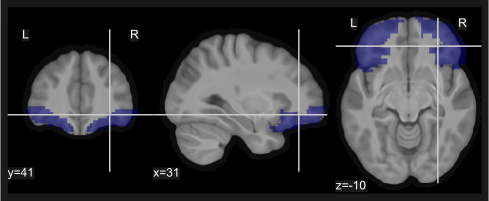

In [5]:
display = plotting.plot_roi(roi_img='./ROI/aal_ROIs/lOFC_MNI2009.nii.gz',bg_img='../FCT_meanT1_structural.nii.gz',cut_coords=(31,41,-10))
print('lateral orbitalfrontal cortex')

medial orbitalfrontal cortex


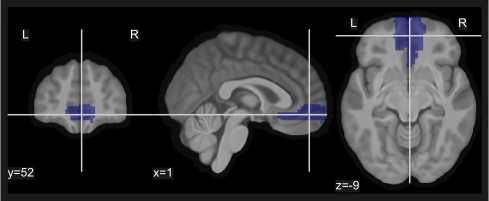

In [6]:
display = plotting.plot_roi(roi_img='./ROI/aal_ROIs/mOFC_MNI2009.nii.gz',bg_img='../FCT_meanT1_structural.nii.gz')
print('medial orbitalfrontal cortex')

In [7]:
df = pd.read_csv('../files/FoodChoice_DTIdemos.csv')
df = df.loc[df['subid']!='FCT_102'] # missing structural scan
df['group'] = df['subtype']==0
df.loc[df['group']==True,'group'] = 'HC'
df.loc[df['group']==False,'group'] = 'AN'
df.groupby(['group']).mean()[['Age','BMI']]

Age        BMI
group                      
AN     26.350000  15.735000
HC     22.714286  21.471429

In [8]:
df.groupby(['group']).agg(np.std)[['Age','BMI']]

Age       BMI
group                    
AN     6.539556  2.078531
HC     3.068271  1.918630

In [9]:
v1 = df.loc[df['group']=='HC','Age']
v2 = df.loc[df['group']=='AN','Age']
stats.ttest_ind(v1,v2)

Ttest_indResult(statistic=-2.2970654504079593, pvalue=0.027068308593309838)

In [10]:
v1 = df.loc[df['group']=='HC','BMI']
v2 = df.loc[df['group']=='AN','BMI']
stats.ttest_ind(v1,v2)

Ttest_indResult(statistic=9.18862757180389, pvalue=2.6565133239523404e-11)

## Load cross-validation scores for within-task classification

In [11]:
"""
Get within-task cross-validation accuracy scores

dir_path (string): path to output files
tag (string): for identifying the outputs 
region (string): ROI (lOFC, mOFC, etc)
"""
def get_cross_val_scores(dir_path,tag,region):
    files = os.listdir(dir_path)
    df = pd.DataFrame()
    for f in files:
        fileinfo = f.split('_')
        subjid = fileinfo[0] # e.g. sub-FCT001
        label = fileinfo[2] 
        fmriresponse = fileinfo[4]
        contents = open(os.path.join(dir_path,f), 'r')
        tmp=contents.read().splitlines()
        crossvalscore = float(tmp[0])*100
        if subjid.startswith('sub-FCT0'):
            group = 'HC'
        else:
            group = 'AN'
        df = df.append({'tag':tag,'region':region,'subjid':subjid,'label':label.replace('-',' '),'fmri_rsp':fmriresponse,'accuracy':crossvalscore,'group':group},ignore_index=True)
    df.sort_values(by='subjid',inplace=True)
    df.reset_index(inplace=True,drop=True) 
    return df

In [12]:
"""
Get permutation test scores for within-task classification

dir_path (string): path to output files
tag (string): for identifying the outputs
region (string): ROI (lOFC, mOFC, etc)
"""
def get_permutation_test_95_percentile(dir_path,tag,region):
    files = os.listdir(dir_path)
    all_perm_data = {}
    for f in files:
        fileinfo = f.split('_')
        subjid = fileinfo[0] # e.g. sub-FCT001
        label = fileinfo[2] 
        fmriresponse = fileinfo[4]
        if subjid.startswith('sub-FCT0'):
            group = 'HC'
        else:
            group = 'AN'
        condition = 'predict_'+label+'_from_'+fmriresponse
        contents = open(os.path.join(dir_path,f), 'r')
        perm_scores=contents.read().splitlines()
        perm_scores = np.asarray(perm_scores).astype(float)
        perm_scores = perm_scores*100
        perm_scores = list(perm_scores)
        if condition not in all_perm_data.keys():
            all_perm_data[condition] = {}
        if group not in all_perm_data[condition].keys():
            all_perm_data[condition][group] = perm_scores
        all_perm_data[condition][group] = np.vstack((all_perm_data[condition][group],perm_scores))
    
    # average permuted cv score across participants for each iteration of permutation test
    group_perm_data = pd.DataFrame()
    for condition in all_perm_data.keys():
        for group in all_perm_data[condition].keys():
            tmp = pd.DataFrame(all_perm_data[condition][group].mean(axis=0)).T
            assert tmp.shape == (1, 1000) # 1000 permutations were performed
            label = condition.split('_')[1]
            fmri_rsp = condition.split('_')[3]
            tmp['group'] = group
            tmp['label'] = label.replace('-',' ')
            tmp['fmri_rsp'] = fmri_rsp
            tmp['tag'] = tag
            tmp['region'] = region
            group_perm_data = group_perm_data.append(tmp,sort=False)
    # get the 95th percentile after averaging across participants for each iteration
    group_perm_data['percentile_value'] = group_perm_data[range(0,1000)].quantile(0.95,axis=1)
    #group_perm_data.drop(columns=range(0,1000),inplace=True)
    return group_perm_data

In [13]:
lOFC_df = get_cross_val_scores('cross_val_scores_model-003/cross_val_scores_lOFC','ratings/objective','lOFC')
mOFC_df = get_cross_val_scores('cross_val_scores_model-003/cross_val_scores_mOFC','ratings/objective','mOFC')

In [14]:
V1_df = get_cross_val_scores('visual_feature_classification_model-003/cross_val_scores_V1','visual_features','V1')

In [15]:
class_results = pd.concat([lOFC_df,mOFC_df,V1_df],axis=0)
class_results.rename(index=str, columns={"accuracy": "Accuracy (%)"},inplace=True)

In [16]:
lOFC_perm_df = get_permutation_test_95_percentile('cross_val_scores_model-003/cross_val_scores_permutation_results_lOFC','ratings/objective','lOFC')
mOFC_perm_df = get_permutation_test_95_percentile('cross_val_scores_model-003/cross_val_scores_permutation_results_mOFC','ratings/objective','mOFC')

In [17]:
V1_perm_df = get_permutation_test_95_percentile('visual_feature_classification_model-003/cross_val_scores_permutation_results_V1','visual_features','V1')

In [18]:
perm_results = pd.concat([lOFC_perm_df,mOFC_perm_df,V1_perm_df],axis=0)

In [19]:
included_labels = ['taste','health','luminance']
class_results = class_results.loc[class_results['label'].isin(included_labels)]
perm_results = perm_results.loc[perm_results['label'].isin(included_labels)]
class_results = class_results.reset_index(drop=True)
perm_results = perm_results.reset_index(drop=True)

## Load in choice data and cross-task classification analyses

In [20]:
"""
Get classifier evidence for cross-task classification

dir_path (string): path to output files
region (string): ROI (lOFC, mOFC, etc)
"""
def get_choice_classification_predictions(dir_path,region):
    files = glob.glob(os.path.join(dir_path,'*classifier_evidence.txt'))
    files.sort()
    clf_pred_df = pd.DataFrame()
    for f in files:
        filename = f.split('/')[-1] # grab the file name, remove folder path
        fileinfo = filename.split('_')
        subjid = fileinfo[0] # sub-FCT001
        label = fileinfo[2] 
        fmriresponse = fileinfo[4]
        if subjid.startswith('sub-FCT0'):
            group = 'HC'
        else:
            group = 'AN'
        col_names = ['prediction']
        sub_df = pd.read_csv(os.path.join(f),sep=',',names=['evidence of low rating','evidence of high rating'])
        sub_df['group'] = group
        sub_df['region'] = region
        sub_df['subjid'] = subjid
        sub_df['label'] = label
        sub_df['fmri_rsp'] = fmriresponse
        sub_df['trial'] = sub_df.index.values # not necessarily trial number since only valid trials
        ev_filename = f[:len(f)-len('classifier_predictions.txt')] + 'classifier_evidence.txt'
        clf_pred_df = pd.concat([clf_pred_df,sub_df],ignore_index=True,sort=False)
    clf_pred_df.reset_index(inplace=True,drop=True) 
    return clf_pred_df

In [21]:
OFC_choices_df = get_choice_classification_predictions('predictions_from_choices_model-003/predict_from_choices_OFC','OFC')

#### get number of valid choice trials

In [22]:
OFC_choices_df.loc[OFC_choices_df['label']=='taste'].groupby(['subjid','group'],as_index=False).count().groupby(['group']).mean()[['trial']]

trial
group           
AN     74.250000
HC     75.380952

In [23]:
OFC_choices_df.loc[OFC_choices_df['label']=='taste'].groupby(['subjid','group'],as_index=False).count().groupby(['group']).agg(np.std)[['trial']]

trial
group          
AN     1.860249
HC     1.160870

In [24]:
choices = OFC_choices_df.loc[OFC_choices_df['label']=='taste'].groupby(['subjid','group'],as_index=False).count()
HC_choices = choices.loc[choices['group']=='HC','trial'].values
AN_choices = choices.loc[choices['group']=='AN','trial'].values
stats.ttest_ind(HC_choices,AN_choices)

Ttest_indResult(statistic=2.3478151205368563, pvalue=0.024050987396330988)

In [25]:
"""
Get behavioral choice data + ratings of choice options
Process raw matlab data files and reorganize into dataframe
"""
def get_choice_data():
    subs = os.listdir('../behav')
    subs.sort()
    data = pd.DataFrame()
    for sub in subs:
        if sub.startswith('sub-'):
            subfiles = os.listdir('../behav/'+sub)
            for f in subfiles:
                if '_h_' in f:
                    health_file_name = f
                elif '_y_' in f:
                    taste_file_name = f
                elif '_c_' in f:
                    choice_file_name = f
            assert health_file_name.startswith('FCT_'+sub[-3:]) and taste_file_name.startswith('FCT_'+sub[-3:]) and choice_file_name.startswith('FCT_'+sub[-3:])
            health = loadmat(os.path.join('..','behav',sub,health_file_name))
            taste = loadmat(os.path.join('..','behav',sub,taste_file_name))
            choices = loadmat(os.path.join('..','behav',sub,choice_file_name))

            health_df = pd.DataFrame()
            health_df['food'] = np.concatenate(health['food'], axis=0)
            health_df['food'] = np.concatenate(health_df['food'], axis=0)
            health_df['health_rating'] = np.concatenate(health['health_rating'], axis=0)

            taste_df = pd.DataFrame()
            taste_df['food'] = np.concatenate(taste['food'], axis=0)
            taste_df['food'] = np.concatenate(taste_df['food'], axis=0)
            taste_df['taste_rating'] = np.concatenate(taste['taste_rating'], axis=0)
            
            # get taste and health ratings with food as index
            food_info = taste_df.merge(health_df,left_on='food',right_on='food')
            food_info = food_info.set_index('food')

            df = pd.DataFrame()
            df['alt_food'] = np.concatenate(choices['food'], axis=0)
            df['alt_food'] = np.concatenate(df['alt_food'], axis=0)
            df['choice_rating'] = np.concatenate(choices['choice_rating'], axis=0)
            
            # rename columns to reflect alternative food before merging with choice data
            food_info_dup = food_info.rename(columns={'taste_rating':'alt_taste_rating','health_rating':'alt_health_rating'})
            food_info_dup.reset_index(inplace=True)
            
            # get reference food
            ref_food = choices['ref_food'][0]
            
            df = df.loc[df['alt_food']!=ref_food]
            
            # get taste and health ratings of alternative foods
            df = df.merge(food_info_dup,left_on='alt_food',right_on='food')
            
            df['ref_food'] = ref_food
            df['ref_taste_rating'] = food_info.loc[ref_food,'taste_rating']
            df['ref_health_rating'] = food_info.loc[ref_food,'health_rating']
            
            df['alt_taste_rating'] = df['alt_taste_rating'].astype(int)
            df['alt_health_rating'] = df['alt_health_rating'].astype(int)
            df['ref_taste_rating'] = df['ref_taste_rating'].astype(int)
            df['ref_health_rating'] = df['ref_health_rating'].astype(int)
            
            df['subjid'] = sub
            if sub.startswith('sub-FCT0'):
                df['group'] = 'HC'
            else:
                df['group'] = 'AN'
            
            df = df.loc[df['choice_rating'] != 0] # drop trials with no response
            
            data = pd.concat([data,df])
    
    # chose alternative (preferred alternative item)
    data['chose_alt'] = data['choice_rating'] > 3
    
    data.loc[data['chose_alt']==False,'chosen_food'] = data.loc[data['chose_alt']==False,'ref_food']
    data.loc[data['chose_alt']==True,'chosen_food'] = data.loc[data['chose_alt']==True,'alt_food']
    
    # get taste/health rating of chosen food (alternative of reference)
    data.loc[data['chose_alt']==False,'chosen_food_taste_rating'] = data.loc[data['chose_alt']==False,'ref_taste_rating']
    data.loc[data['chose_alt']==True,'chosen_food_taste_rating'] = data.loc[data['chose_alt']==True,'alt_taste_rating']
    data.loc[data['chose_alt']==False,'chosen_food_health_rating'] = data.loc[data['chose_alt']==False,'ref_health_rating']
    data.loc[data['chose_alt']==True,'chosen_food_health_rating'] = data.loc[data['chose_alt']==True,'alt_health_rating']

    return data

In [26]:
choice_data = get_choice_data()

In [27]:
"""
Perform median split on ratings
Note: the median column in the returned dataframe is not exactly the median
The value returned in the median column is the rating number for the second bin (second_bin_starting_rating)
In the classification scripts, "low" class items have values less than second_bin_starting_rating
"high" class items have values greater than OR EQUAL to second_bin_starting_rating
"""
def get_rating_medians():
    subs = os.listdir('../behav')
    subs.sort()
    df = pd.DataFrame()
    ratings = ['taste_rating','health_rating']
    for subjid in subs:
        if subjid.startswith('sub-FCT'):
            for ratingType in ratings:
                behav_dir = os.path.join('..','behav')
                median = trial_class_median_split_py3.get_second_bin_starting_rating(subjid,ratingType,behav_dir)
                tmp = ratingType.split('_')
                label = tmp[0]
                if subjid.startswith('sub-FCT0'):
                    group = 'HC'
                else:
                    group = 'AN'
                df = df.append({'subjid':subjid,'group':group,'label':label,'median':median},ignore_index=True)
    return df

In [28]:
median_df = get_rating_medians()

In [29]:
# merge behavioral data (median_df) with imaging results (OFC_choices_df)
df = OFC_choices_df.merge(median_df,on=['subjid','label','group'])

In [30]:
# retrieve the specific food and choice rating on each trial
subs = os.listdir('../behav')
subs.sort()
ratings = ['taste_rating','health_rating']
ratingNames = {'taste_rating':'taste','health_rating':'health'}
for subjid in subs:
    if subjid.startswith('sub-FCT'):
        for ratingType in ratings:
            sub_df = df.loc[(df['subjid']==subjid) & (df['label']==ratingNames[ratingType])]
            if len(sub_df) > 0: # exception of 102, which was excluded because of missing anat image
                behav_dir = '../behav'
                choice_trials = trial_class_median_split_py3.get_choice_trials(subjid,behav_dir);
                choice_trials = choice_trials.loc[choice_trials['choice_rating']!=0]
                assert len(sub_df) == len(choice_trials)
                df.loc[(df['subjid']==subjid) & (df['label']==ratingNames[ratingType]),'food'] = choice_trials['food'].values
                df.loc[(df['subjid']==subjid) & (df['label']==ratingNames[ratingType]),'choice_rating'] = choice_trials['choice_rating'].values

In [31]:
OFC_choices_df = df

In [32]:
full_choice_data = OFC_choices_df.merge(choice_data,left_on=['subjid','food','group','choice_rating'],right_on=['subjid','food','group','choice_rating'])

In [33]:
full_choice_data = full_choice_data.rename(columns={'evidence of low rating':'evidence_of_low_rating','evidence of high rating':'evidence_of_high_rating'})

In [34]:
# NOTE: median column refers to adjusted (after matching high/low bin sizes) median rating of the corresponding label (taste/health)
# when label == taste, chosen_food_high_health_rating is meaningless
# when label == health, chosen_food_high_taste_rating is meaningless
# analyses are only conducted on taste_data and health_data, where the only correct columns are used

# evidence_of_high_rating also corresponds to the label

In [35]:
full_choice_data['chosen_food_high_taste_rating'] = (full_choice_data['chosen_food_taste_rating'] >= full_choice_data['median']).astype(int)
full_choice_data['chosen_food_high_health_rating'] = (full_choice_data['chosen_food_health_rating'] >= full_choice_data['median']).astype(int)

In [36]:
full_choice_data['alt_taste_rating'] = full_choice_data['alt_taste_rating'].astype(int)
full_choice_data['alt_health_rating'] = full_choice_data['alt_health_rating'].astype(int)

In [37]:
full_choice_data['alt_food_high_taste_rating'] = (full_choice_data['alt_taste_rating'] >= full_choice_data['median']).astype(int)
full_choice_data['alt_food_high_health_rating'] = (full_choice_data['alt_health_rating'] >= full_choice_data['median']).astype(int)

# whether alternative item is tasty/healthy (not based on median split)
full_choice_data['alternative'] = full_choice_data['alt_taste_rating'] >= 4
full_choice_data['alternative'] = full_choice_data['alt_health_rating'] >= 4
full_choice_data.loc[full_choice_data['label']=='taste','alternative'] = full_choice_data['alternative'].replace({True:'0_Tasty',False:'1_Not_Tasty'})
full_choice_data.loc[full_choice_data['label']=='health','alternative'] = full_choice_data['alternative'].replace({True:'0_Healthy',False:'1_Not_Healthy'})

In [38]:
taste_data = full_choice_data.loc[full_choice_data['label']=='taste'].copy()
health_data = full_choice_data.loc[full_choice_data['label']=='health'].copy()

In [39]:
# remove items where alternative rating is missing
taste_data = taste_data.loc[taste_data['alt_taste_rating']!=0]
health_data = health_data.loc[health_data['alt_health_rating']!=0]

# remove choice trials with neutral rating (neither item was chosen)
taste_data = taste_data.loc[taste_data['choice_rating']!=3]
health_data = health_data.loc[health_data['choice_rating']!=3]

In [40]:
# check if high/low classifier evidence matches high/low label of chosen food
taste_data.loc[:,'predicted_taste_matches_chosen_food_taste'] = ((taste_data.loc[:,'evidence_of_high_rating']>=.5) == taste_data.loc[:,'chosen_food_high_taste_rating']).astype(int)*100
health_data.loc[:,'predicted_health_matches_chosen_food_health'] = ((health_data.loc[:,'evidence_of_high_rating']>=.5) == health_data.loc[:,'chosen_food_high_health_rating']).astype(int)*100

In [41]:
# check if high/low classifier evidence matches high/low label of alternative (trial-specific) food
taste_data.loc[:,'predicted_taste_matches_alt_food_taste'] = ((taste_data.loc[:,'evidence_of_high_rating']>=.5) == taste_data.loc[:,'alt_food_high_taste_rating']).astype(int)*100
health_data.loc[:,'predicted_health_matches_alt_food_health'] = ((health_data.loc[:,'evidence_of_high_rating']>=.5) == health_data.loc[:,'alt_food_high_health_rating']).astype(int)*100

number of choice trials, after removing choices with rating = 3 and removing choices where rating of alt food was not provided

In [42]:
taste_data.groupby(['subjid','group'],as_index=True).count().groupby(['group'],as_index=True).mean()[['trial']]

trial
group           
AN     60.750000
HC     69.857143

In [43]:
taste_data.groupby(['subjid','group'],as_index=True).count().groupby(['group'],as_index=True).agg(np.std)[['trial']]

trial
group          
AN     8.110260
HC     4.860923

In [44]:
v1 = taste_data.loc[taste_data['group']=='HC'].groupby(['subjid','group'],as_index=False).count()['trial']
v2 = taste_data.loc[taste_data['group']=='AN'].groupby(['subjid','group'],as_index=False).count()['trial']
stats.ttest_ind(v1,v2)

Ttest_indResult(statistic=4.3862165269869715, pvalue=8.488878882062863e-05)

In [45]:
health_data.groupby(['subjid','group'],as_index=True).count().groupby(['group'],as_index=True).mean()[['trial']]

trial
group           
AN     61.350000
HC     70.285714

In [46]:
health_data.groupby(['subjid','group'],as_index=True).count().groupby(['group'],as_index=True).agg(np.std)[['trial']]

trial
group          
AN     8.628441
HC     4.681270

In [47]:
v1 = health_data.loc[health_data['group']=='HC'].groupby(['subjid','group'],as_index=False).count()['trial']
v2 = health_data.loc[health_data['group']=='AN'].groupby(['subjid','group'],as_index=False).count()['trial']
stats.ttest_ind(v1,v2)

Ttest_indResult(statistic=4.1493095698460705, pvalue=0.00017478696506448882)

## Load ratings

In [48]:
subs = os.listdir('../behav')
subs.sort()
data = pd.DataFrame()
for sub in subs:
    if sub.startswith('sub-'):
        subfiles = os.listdir('../behav/'+sub)
        for f in subfiles:
            if '_h_' in f:
                health_file_name = f
            elif '_y_' in f:
                taste_file_name = f
        health = loadmat(os.path.join('..','behav',sub,health_file_name))
        taste = loadmat(os.path.join('..','behav',sub,taste_file_name))

        health_df = pd.DataFrame()
        health_df['food'] = np.concatenate(health['food'], axis=0)
        health_df['food'] = np.concatenate(health_df['food'], axis=0)
        health_df['health_rating'] = np.concatenate(health['health_rating'], axis=0)
        health_df['fat'] = np.concatenate(health['fat'], axis=0)

        taste_df = pd.DataFrame()
        taste_df['food'] = np.concatenate(taste['food'], axis=0)
        taste_df['food'] = np.concatenate(taste_df['food'], axis=0)
        taste_df['taste_rating'] = np.concatenate(taste['taste_rating'], axis=0)

        food_info = taste_df.merge(health_df,left_on='food',right_on='food')
        food_info['subjid'] = sub
        food_info['group'] = 'HC' if sub.startswith('sub-FCT0') else 'AN'
        data = pd.concat([data,food_info])
data['taste_rating'] = data['taste_rating'].replace({0:np.nan}) # remove trials without response
data['health_rating'] = data['health_rating'].replace({0:np.nan})

In [49]:
rating_data = data

#### get number of valid rating trials

##### taste ratings

In [50]:
taste_ratings = data[['group','subjid','taste_rating']]
taste_ratings = taste_ratings.loc[~np.isnan(taste_ratings['taste_rating'])]
taste_ratings = taste_ratings.groupby(['subjid','group'],as_index=False).count()

In [51]:
print('mean number of valid taste rating trials')
taste_ratings.groupby(['group'],as_index=False).mean()

mean number of valid taste rating trials


group  taste_rating
0    AN     73.952381
1    HC     75.238095

In [52]:
print('std number of valid taste rating trials')
taste_ratings.groupby(['group'],as_index=False).agg(np.std)

std number of valid taste rating trials


group  taste_rating
0    AN      4.200907
1    HC      1.179185

In [53]:
stats.ttest_ind(taste_ratings.loc[taste_ratings['group']=='HC','taste_rating'],taste_ratings.loc[taste_ratings['group']=='AN','taste_rating'])

Ttest_indResult(statistic=1.350337626615264, pvalue=0.18449882850439112)

##### health ratings

In [54]:
health_ratings = data[['group','subjid','health_rating']]
health_ratings = health_ratings.loc[~np.isnan(health_ratings['health_rating'])]
health_ratings = health_ratings.groupby(['subjid','group'],as_index=False).count()

In [55]:
print('mean number of valid health rating trials')
health_ratings.groupby(['group'],as_index=False).mean()

mean number of valid health rating trials


group  health_rating
0    AN      74.380952
1    HC      75.571429

In [56]:
print('std number of valid health rating trials')
health_ratings.groupby(['group'],as_index=False).agg(np.std)

std number of valid health rating trials


group  health_rating
0    AN       2.011870
1    HC       0.597614

In [57]:
stats.ttest_ind(health_ratings.loc[health_ratings['group']=='HC','health_rating'],health_ratings.loc[health_ratings['group']=='AN','health_rating'])

Ttest_indResult(statistic=2.599376224550181, pvalue=0.013018153906408592)

In [58]:
t_choice_data = taste_data.groupby(['subjid','group'],as_index=False).mean()[['subjid','group','chosen_food_high_taste_rating','choice_rating']]
t_choice_data['attribute'] = 'Tastiness'
t_choice_data.rename(columns={'chosen_food_high_taste_rating':'Chose higher rated food'},inplace=True)
h_choice_data = health_data.groupby(['subjid','group'],as_index=False).mean()[['subjid','group','chosen_food_high_health_rating','choice_rating']]
h_choice_data['attribute'] = 'Healthiness'
h_choice_data.rename(columns={'chosen_food_high_health_rating':'Chose higher rated food'},inplace=True)
choice_data_grouped = pd.concat([t_choice_data,h_choice_data])

### get group-level median ratings

In [59]:
data = rating_data

In [60]:
HC_med_ratings = data.loc[data['group']=='HC'].groupby(['subjid','group'],as_index=False).median()

In [61]:
HC_med_ratings.mean()[['taste_rating','health_rating']]

taste_rating     3.952381
health_rating    3.190476
dtype: float64

In [62]:
HC_med_ratings[['taste_rating','health_rating']].agg(np.std)

taste_rating     0.589592
health_rating    0.601585
dtype: float64

In [63]:
AN_med_ratings = data.loc[data['group']=='AN'].groupby(['subjid','group'],as_index=False).median()

In [64]:
AN_med_ratings.mean()[['taste_rating','health_rating']]

taste_rating     2.904762
health_rating    2.595238
dtype: float64

In [65]:
AN_med_ratings[['taste_rating','health_rating']].agg(np.std)

taste_rating     0.830949
health_rating    0.663684
dtype: float64

In [66]:
stats.ttest_ind(HC_med_ratings['taste_rating'],AN_med_ratings['taste_rating'])

Ttest_indResult(statistic=4.711882305659314, pvalue=2.951276901224152e-05)

In [67]:
stats.ttest_ind(HC_med_ratings['health_rating'],AN_med_ratings['health_rating'])

Ttest_indResult(statistic=3.0451596070881, pvalue=0.004102025979998826)

## Save data to csv files

In [68]:
if not os.path.exists('compiled_data_spreadsheets'):
    os.mkdir('compiled_data_spreadsheets')

#### save behavioral data to csv files

In [69]:
rating_data = rating_data[['subjid','group','food','taste_rating','health_rating']]
rating_data.reset_index(drop=True,inplace=True)
rating_data.to_csv('compiled_data_spreadsheets/rating_data.csv',index=False)

In [70]:
choice_data = choice_data[['subjid','group','ref_food','alt_food','choice_rating']]
choice_data.to_csv('compiled_data_spreadsheets/choice_rating_data.csv',index=False)

#### save within-task decoding scores to csv files

In [71]:
class_results.rename(columns={'Accuracy (%)':'within_task_decoding_accuracy',
                             'fmri_rsp':'rating_block_fmri_activity'},inplace=True)
class_results.drop(columns=['tag'],inplace=True)
class_results['within_task_decoding_accuracy'] = class_results['within_task_decoding_accuracy']
class_results = class_results.loc[(class_results['label']==class_results['rating_block_fmri_activity']) | (class_results['label']=='luminance')]
class_results.reset_index(drop=True,inplace=True)

In [72]:
perm_results.rename(columns={'fmri_rsp':'rating_block_fmri_activity',
                            'percentile_value':'percentile_95'
                            },inplace=True)
perm_results.drop(columns=['tag'],inplace=True)
perm_results = perm_results.loc[(perm_results['label']==perm_results['rating_block_fmri_activity']) | (perm_results['label']=='luminance')]
perm_results.reset_index(drop=True,inplace=True)

In [73]:
## rename column names for clarity
#column_dict = {}
#for i in range(0,1000):
#    column_dict[i] = 'permutation_test_iteration_%s'%(i)
#perm_results.rename(columns=column_dict,inplace=True)

In [74]:
perm_results.iloc[:,0:1000] = perm_results.iloc[:,0:1000].copy()
perm_results.loc[:,'percentile_value'] = perm_results.loc[:,'percentile_95'].copy()

In [75]:
class_results.to_csv('compiled_data_spreadsheets/within_task_decoding_accuracies.csv',index=False)

In [76]:
perm_results.to_csv('compiled_data_spreadsheets/within_task_decoding_permutation_scores.csv',index=False)

#### save choice decoding scores to csv files

In [77]:
taste_data_mod = taste_data.copy()
health_data_mod = health_data.copy()

In [78]:
# recode HC as 0 and AN as 1 for regression models
taste_data_mod['groupN']=taste_data_mod['group'].replace({'HC':0,'AN':1})
health_data_mod['groupN']=health_data_mod['group'].replace({'HC':0,'AN':1})

In [79]:
taste_data_mod = taste_data_mod[['subjid','groupN','group','label','chosen_food_high_taste_rating','choice_rating','evidence_of_high_rating','predicted_taste_matches_chosen_food_taste','predicted_taste_matches_alt_food_taste','alternative']]
health_data_mod = health_data_mod[['subjid','groupN','group','label','chosen_food_high_health_rating','choice_rating','evidence_of_high_rating','predicted_health_matches_chosen_food_health','predicted_health_matches_alt_food_health','alternative']]

In [80]:
taste_data_mod.rename(columns={'chosen_food_high_taste_rating':'chosen_food_high_rating',
                           'evidence_of_high_rating':'classifier_evidence',
                           'predicted_taste_matches_chosen_food_taste':'cross_task_accuracy',
                           'predicted_taste_matches_alt_food_taste':'cross_task_accuracy_alt'},inplace=True)
taste_data_mod.reset_index(drop=True,inplace=True)
taste_data_mod['cross_task_accuracy'] = taste_data_mod['cross_task_accuracy']/100 # rescale from 0-100 to 0-1
taste_data_mod['cross_task_accuracy_alt'] = taste_data_mod['cross_task_accuracy_alt']/100 # rescale from 0-100 to 0-1

In [81]:
health_data_mod = health_data_mod.copy()
health_data_mod.rename(columns={'chosen_food_high_health_rating':'chosen_food_high_rating',
                           'evidence_of_high_rating':'classifier_evidence',
                           'predicted_health_matches_chosen_food_health':'cross_task_accuracy',
                           'predicted_health_matches_alt_food_health':'cross_task_accuracy_alt'},inplace=True)
health_data_mod.reset_index(drop=True,inplace=True)
health_data_mod['cross_task_accuracy'] = health_data_mod['cross_task_accuracy']/100 # rescale from 0-100 to 0-1
health_data_mod['cross_task_accuracy_alt'] = health_data_mod['cross_task_accuracy_alt']/100 # rescale from 0-100 to 0-1

In [82]:
df = pd.concat([taste_data_mod,health_data_mod])

In [83]:
df.to_csv('compiled_data_spreadsheets/cross_task_decoding_accuracies.csv',index=False)

In [84]:
df = pd.read_csv('compiled_data_spreadsheets/cross_task_decoding_accuracies.csv')

## Plotting functions

In [85]:
"""
Plot line for 95th percentile of null distribution

null_dist (dataframe row, [1 rows x 1000 columns]): null distribution
percentile_95 (float): 95th percentile of null distribution
sample_mean (float): sample mean of interest (cross-validation accuracy)
ax (matplotlib axes): axis to plot onto
x_pos (float): x coordinate indicating where to plot lie
markersize (float): length of line
markeredgewidth (float): thickness of line
condition (dictionary): for saving permutation test results, just ignore
"""

def plot_permutation_test_results(null_dist,percentile_95,sample_mean,ax,x_pos,markersize,markeredgewidth,condition={}):
    ax.plot(x_pos, percentile_95, '_', color='gray',markersize=markersize,markeredgewidth=markeredgewidth,zorder=0)
    # this is confusing but null_dist.values[0] extracts the values from the dataframe row
    # null_dist.values[0] is an array of 1000 values
    perm_test = np.mean(null_dist.values[0] > sample_mean)
    # print the proportion of values in the null distribution are greater than the sample mean
    print("permutation test:", perm_test)
    print('')

<a id='fig1'></a>
## Figure 1: Behavioral ratings and choices

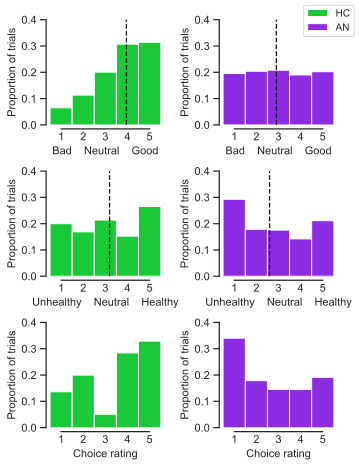

In [86]:
fig,axes = plt.subplots(3,2,sharex=False,figsize=(5,6.5),dpi=120)

data = rating_data

axes[0][0].hist(data.loc[data['group']=='HC','taste_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='g', label='HC')
axes[1][0].hist(data.loc[data['group']=='HC','health_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='g')
# get median rating for each subject
data_med = data.loc[data['group']=='HC'].groupby(['subjid','group'],as_index=False).median()
axes[0][0].axvline(data_med['taste_rating'].mean(), color='k', linestyle='dashed', linewidth=1.3)
# get median rating for each subject
data_med = data.loc[data['group']=='HC'].groupby(['subjid','group'],as_index=False).median()
axes[1][0].axvline(data_med['health_rating'].mean(), color='k', linestyle='dashed', linewidth=1.3)

axes[0][1].hist(data.loc[data['group']=='AN','taste_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='m',label='AN')
axes[1][1].hist(data.loc[data['group']=='AN','health_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='m')
# get median rating for each subject
data_med = data.loc[data['group']=='AN'].groupby(['subjid','group'],as_index=False).median()
axes[0][1].axvline(data_med['taste_rating'].mean(), color='k', linestyle='dashed', linewidth=1.3)
# get median rating for each subject
data_med = data.loc[data['group']=='AN'].groupby(['subjid','group'],as_index=False).median()
axes[1][1].axvline(data_med['health_rating'].mean(), color='k', linestyle='dashed', linewidth=1.3)

axes[2][0].hist(choice_data.loc[choice_data['group']=='HC','choice_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='g')
axes[2][1].hist(choice_data.loc[choice_data['group']=='AN','choice_rating'], density=True, bins=[1,2,3,4,5,6], align='left', color='m')

for ax in axes.flatten():
    ax.set_xticks(ticks=[1,2,3,4,5])
    ax.tick_params(axis='x',length=0)
    ax.set_ylim([0,0.4])
    ax.set_xlim([0.5,5.5])
    ax.set_yticks(ticks=[0,0.1,0.2,0.3,0.4])
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.set_ylabel('Proportion of trials',fontsize=11)
    
axes[0][0].set_xlabel('Bad    Neutral    Good',fontsize=11)
axes[0][1].set_xlabel('Bad    Neutral    Good',fontsize=11)
axes[1][0].set_xlabel('Unhealthy    Neutral    Healthy',fontsize=11)
axes[1][1].set_xlabel('Unhealthy    Neutral    Healthy',fontsize=11)

axes[2][0].set_xlabel('Choice rating',fontsize=11)
axes[2][1].set_xlabel('Choice rating',fontsize=11)

plt.suptitle('',fontsize=10,y=1.01)
fig.legend(fontsize=10)

plt.tight_layout()
sns.despine(offset=4,trim=True)

plt.savefig('FINAL_FIGURES/behavior_plots.png',bbox_inches='tight',dpi=500)
plt.savefig('FINAL_FIGURES/behavior_plots.svg',bbox_inches='tight',dpi=500)
plt.show()

<a id='fig2'></a>
## Figure 2: methods schematic  
![methods schematic](FINAL_FIGURES/combined_figures/methods_schematic.png)

<a id='fig3abc'></a>
## Figure 3a-3c: Within-task classification

taste lOFC HC
permutation test: 0.001

taste mOFC HC
permutation test: 0.0

taste lOFC AN
permutation test: 0.0

taste mOFC AN
permutation test: 0.0

health lOFC HC
permutation test: 0.0

health mOFC HC
permutation test: 0.0

health lOFC AN
permutation test: 0.001

health mOFC AN
permutation test: 0.002

luminance taste HC
luminance health HC
permutation test: 0.0

luminance taste AN
luminance health AN
permutation test: 0.0



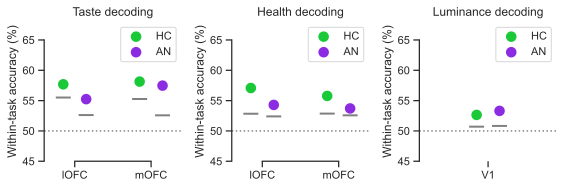

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(8,3), sharex=False, dpi=120)
axes[0].axhline(y=50,linestyle=':',color='gray',zorder=0)
width = .3
dodge = .3

sns.set(style="ticks", palette="bright", color_codes=True, font_scale=1)

### PLOT TASTE DECODING
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')].copy()
perm_data = perm_results.loc[(perm_results['label']=='taste') & (perm_results['rating_block_fmri_activity']=='taste')].copy()

sns.pointplot(x='region', y='within_task_decoding_accuracy', hue='group', palette=["g", "m"], order=['lOFC','mOFC'], ci=None, scale=1.2, dodge=dodge, join=False, data=data, ax=axes[0])
#axes[0].get_legend().remove()
axes[0].get_legend().set_title('')

order = [{'region':'lOFC','group':'HC','x_pos_sig':0-width/4,'x_pos_perm':0-dodge/2},{'region':'mOFC','group':'HC','x_pos_sig':1-width/4,'x_pos_perm':1-dodge/2},{'region':'lOFC','group':'AN','x_pos_sig':0+width/4,'x_pos_perm':0+dodge/2},{'region':'mOFC','group':'AN','x_pos_sig':1+width/4,'x_pos_perm':1+dodge/2}]

for i in range(len(order)):
    region = order[i]['region']
    group = order[i]['group']
    # indicate significance
    subdata = data.loc[(data['region']==region) & (data['group']==group)].copy()
    
    print('taste', region, group)
    null_dist = perm_data.loc[(perm_data['group']==group) & (perm_data['region']==region)].copy()
    assert null_dist.shape == (1,1006)
    val = null_dist['percentile_value'].values[0]
    null_dist = null_dist[range(1000)] # remove misc. columns, just get values in null distribution
    assert null_dist.shape == (1,1000)
    
    plot_permutation_test_results(null_dist,val,subdata['within_task_decoding_accuracy'].mean(),axes[0],order[i]['x_pos_perm'],15,2,{'label':'taste','fmri_rsp':'taste','tag':'ratings/objective','region':region,'group':group})

### PLOT HEALTH DECODING
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')].copy()
perm_data = perm_results.loc[(perm_results['label']=='health') & (perm_results['rating_block_fmri_activity']=='health')].copy()

sns.pointplot(x='region', y='within_task_decoding_accuracy', hue='group', palette=["g", "m"], order=['lOFC','mOFC'], ci=None, scale=1.2, dodge=dodge, join=False, data=data, ax=axes[1])
#axes[1].get_legend().remove()
axes[1].get_legend().set_title('')

order = [{'region':'lOFC','group':'HC','x_pos_sig':0-width/4,'x_pos_perm':0-dodge/2},{'region':'mOFC','group':'HC','x_pos_sig':1-width/4,'x_pos_perm':1-dodge/2},{'region':'lOFC','group':'AN','x_pos_sig':0+width/4,'x_pos_perm':0+dodge/2},{'region':'mOFC','group':'AN','x_pos_sig':1+width/4,'x_pos_perm':1+dodge/2}]

for i in range(len(order)):
    region = order[i]['region']
    group = order[i]['group']
    # indicate significance
    subdata = data.loc[(data['region']==region) & (data['group']==group)].copy()
    
    print('health', region, group)
    null_dist = perm_data.loc[(perm_data['group']==group) & (perm_data['region']==region)].copy()
    assert null_dist.shape == (1,1006) 
    val = null_dist['percentile_value'].values[0]
    null_dist = null_dist[range(1000)] # remove misc. columns, just get values in null distribution
    assert null_dist.shape == (1,1000)
    
    plot_permutation_test_results(null_dist,val,subdata['within_task_decoding_accuracy'].mean(),axes[1],order[i]['x_pos_perm'],15,2,{'label':'taste','fmri_rsp':'taste','tag':'ratings/objective','region':region,'group':group})
    
### PLOT LUMINANCE DECODING
data = class_results.loc[class_results['label']=='luminance'].copy()
perm_data = perm_results.loc[perm_results['label']=='luminance'].copy()

g = sns.pointplot(x='region', y='within_task_decoding_accuracy', hue='group', palette=["g", "m"], ci=None, scale=1.2, dodge=dodge, join=False, data=data)

order = [{'group':'HC','x_pos_sig':0-width/8,'x_pos_perm':0-dodge/2},{'group':'AN','x_pos_sig':0+width/8,'x_pos_perm':0+dodge/2}]

for i in range(len(order)):
    group = order[i]['group']
    fmri_rsp = 'taste'
    subdata = data.loc[(data['rating_block_fmri_activity']==fmri_rsp) & (data['group']==group)].copy()
    print('luminance', fmri_rsp, group)
    null_dist = perm_data.loc[(perm_data['group']==group) & (perm_data['rating_block_fmri_activity']==fmri_rsp)]
    assert null_dist.shape == (1,1006) 
    null_dist = null_dist[range(1000)] # remove misc. columns, just get values in null distribution
    assert null_dist.shape == (1,1000)
    null_dist_1 = null_dist

    fmri_rsp = 'health'
    subdata = data.loc[(data['rating_block_fmri_activity']==fmri_rsp) & (data['group']==group)].copy()
    print('luminance', fmri_rsp, group)
    null_dist = perm_data.loc[(perm_data['group']==group) & (perm_data['rating_block_fmri_activity']==fmri_rsp)]
    assert null_dist.shape == (1,1006) 
    null_dist = null_dist[range(1000)] # remove misc. columns, just get values in null distribution
    assert null_dist.shape == (1,1000)
    null_dist_2 = null_dist

    null_dist = pd.concat([null_dist_1,null_dist_2])
    # take mean of permuted cross validation scores across each iteration
    null_dist = null_dist.mean(axis=0)
    val = np.quantile(null_dist,0.95)
    #print('95th percentile',val)
    
    subdata = data.loc[data['group']==group].copy()
    subdata = subdata.groupby(['rating_block_fmri_activity'],as_index=False).mean()
    plot_permutation_test_results(null_dist,val,subdata['within_task_decoding_accuracy'].mean(),fig.gca(),order[i]['x_pos_perm'],15,2,{'label':'luminance','fmri_rsp':fmri_rsp,'tag':'visual_features','region':region,'group':group})

plt.legend(loc='upper right')
axes[1].axhline(y=50,linestyle=':',color='gray',zorder=0)
axes[2].axhline(y=50,linestyle=':',color='gray',zorder=0)
axes[0].set_ylim(45,68)
axes[1].set_ylim(45,68)
axes[2].set_ylim(45,68)
axes[0].set_ylabel('Within-task accuracy (%)')
axes[1].set_ylabel('Within-task accuracy (%)')
axes[2].set_ylabel('Within-task accuracy (%)')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[0].set_title('Taste decoding')
axes[1].set_title('Health decoding')
axes[2].set_title('Luminance decoding')
#sns.despine(top=True, right=True, ax=axes[0])
#sns.despine(top=True, right=True, ax=axes[1])
#sns.despine(top=True, right=True, ax=axes[2])
sns.despine(trim=True, ax=axes[0])
sns.despine(trim=True, ax=axes[1])
sns.despine(trim=True, ax=axes[2])

axes[0].set_xlim(-0.4,1.4)
axes[1].set_xlim(-0.4,1.4)
axes[2].set_xlim(-0.9,0.9)

plt.tight_layout()
plt.subplots_adjust(top=0.8)
#fig.suptitle('Decoding of taste and health from the OFC') 
plt.savefig('FINAL_FIGURES/taste_health_luminance_decoding.png', bbox_inches = "tight", dpi=500)
plt.savefig('FINAL_FIGURES/taste_health_luminance_decoding.svg', bbox_inches = "tight", dpi=500)
plt.show()

### Conduct permutation test to compare groups (for each ROI separately)

In [88]:
"""
Generic function for performing permutation test to compare cross-validation scores across groups/ROIs
Note output will vary each time because of random shuffling!

data: array of accuracy scores for both groups
n_data_in_group_1: number of data points in group 1 (HC)
diff: difference between groups that you're testing the permutation test against
"""
def do_perm_test(data,n_data_in_group_1,diff):
    acc = data['within_task_decoding_accuracy'].values
    perm_diff = np.zeros(1000)
    for i in range(0,1000): # 1000 shuffles
        random.shuffle(acc)
        fake_group1 = acc[0:n_data_in_group_1] # HC
        fake_group2 = acc[n_data_in_group_1:] # AN
        perm_diff[i] = fake_group1.mean() - fake_group2.mean()
    print('95th percentile:', np.quantile(perm_diff,0.95))
    print('p='+str(np.mean(perm_diff > diff)))
    return perm_diff

#### taste

In [89]:
data_m = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
data_m = data_m.groupby(['region','group'],as_index=False).mean()
data_m

region group  within_task_decoding_accuracy
0   lOFC    AN                      55.239692
1   lOFC    HC                      57.689362
2   mOFC    AN                      57.472904
3   mOFC    HC                      58.134921

In [90]:
'taste, lOFC: HC - AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('taste, lOFC: HC - AN', 2.4496699264501416)

In [91]:
'taste, mOFC: HC - AN',data_m.iloc[3]['within_task_decoding_accuracy'] - data_m.iloc[2]['within_task_decoding_accuracy']

('taste, mOFC: HC - AN', 0.6620165610103754)

#### taste, lOFC: HC > AN

In [92]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
data = data.loc[(data['region']=='lOFC')]
assert len(data) == 41
taste_lOFC_null_dist = do_perm_test(data,21,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 4.27608433724366
p=0.192


#### taste, mOFC: HC > AN

In [93]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
data = data.loc[(data['region']=='mOFC')]
assert len(data) == 41
taste_mOFC_null_dist = do_perm_test(data,21,data_m.iloc[3]['within_task_decoding_accuracy'] - data_m.iloc[2]['within_task_decoding_accuracy'])

95th percentile: 3.7174899930732583
p=0.425


#### health

In [94]:
data_m = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
data_m = data_m.groupby(['region','group'],as_index=False).mean()
data_m

region group  within_task_decoding_accuracy
0   lOFC    AN                      54.291366
1   lOFC    HC                      57.076720
2   mOFC    AN                      53.709150
3   mOFC    HC                      55.774854

In [95]:
'health, lOFC: HC - AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('health, lOFC: HC - AN', 2.7853539076449465)

In [96]:
'health, mOFC: HC - AN',data_m.iloc[3]['within_task_decoding_accuracy'] - data_m.iloc[2]['within_task_decoding_accuracy']

('health, mOFC: HC - AN', 2.0657034743722207)

#### health, lOFC: HC > AN

In [97]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
data = data.loc[(data['region']=='lOFC')]
assert len(data) == 41
health_lOFC_null_dist = do_perm_test(data,21,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 4.235053012433034
p=0.139


#### health, mOFC: HC > AN

In [98]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
data = data.loc[(data['region']=='mOFC')]
assert len(data) == 41
health_mOFC_null_dist = do_perm_test(data,21,data_m.iloc[3]['within_task_decoding_accuracy'] - data_m.iloc[2]['within_task_decoding_accuracy'])

95th percentile: 3.9483205562926793
p=0.201


### conduct permutation test to compare decoding accuracy across subregions

#### taste

In [99]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 82
data_m = data.groupby(['region'],as_index=False).mean()
data_m

region  within_task_decoding_accuracy
0   lOFC                      56.494401
1   mOFC                      57.811986

In [100]:
'taste, lOFC-mOFC',data_m.iloc[0]['within_task_decoding_accuracy'] - data_m.iloc[1]['within_task_decoding_accuracy']

('taste, lOFC-mOFC', -1.3175843722169986)

In [101]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 82
taste_region_null_dist = do_perm_test(data,41,data_m.iloc[0]['within_task_decoding_accuracy'] - data_m.iloc[1]['within_task_decoding_accuracy'])

95th percentile: 2.7832583611108004
p=0.773


#### health

In [102]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 82
data_m = data.groupby(['region'],as_index=False).mean()
data_m

region  within_task_decoding_accuracy
0   lOFC                      55.718010
1   mOFC                      54.767194

In [103]:
'health, lOFC-mOFC',data_m.iloc[0]['within_task_decoding_accuracy'] - data_m.iloc[1]['within_task_decoding_accuracy']

('health, lOFC-mOFC', 0.950816783709648)

In [104]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 82
health_region_null_dist = do_perm_test(data,41,data_m.iloc[0]['within_task_decoding_accuracy'] - data_m.iloc[1]['within_task_decoding_accuracy'])

95th percentile: 3.1935844513243983
p=0.323


### conduct permutation test to compare decoding accuracies between groups

#### taste

In [105]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 82
data_m = data.groupby(['group'],as_index=False).mean()
data_m

group  within_task_decoding_accuracy
0    AN                      56.356298
1    HC                      57.912141

In [106]:
'taste, HC-AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('taste, HC-AN', 1.5558432437302656)

In [107]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
assert len(data) == 82
taste_group_null_dist = do_perm_test(data,41,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 2.8733436892086637
p=0.189


#### health

In [108]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 82
data_m = data.groupby(['group'],as_index=False).mean()
data_m

group  within_task_decoding_accuracy
0    AN                      54.000258
1    HC                      56.425787

In [109]:
'health, HC-AN',data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy']

('health, HC-AN', 2.425528691008587)

In [110]:
data = class_results.loc[(class_results['label']=='health') & (class_results['rating_block_fmri_activity']=='health')]
assert len(data) == 82
health_group_null_dist = do_perm_test(data,41,data_m.iloc[1]['within_task_decoding_accuracy'] - data_m.iloc[0]['within_task_decoding_accuracy'])

95th percentile: 2.9903114433621107
p=0.101


<a id='fig4a'></a>
## Figure 4a: use taste evidence to predict choices

R[write to console]: boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
chosen_food_high_rating ~ classifier_evidence * groupN + (classifier_evidence |  
    subjid)
   Data: taste_data_mod

     AIC      BIC   logLik deviance df.resid 
  3096.5   3137.8  -1541.3   3082.5     2675 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4537 -0.7540 -0.3788  0.8280  2.8029 

Random effects:
 Groups Name                Variance Std.Dev. Corr
 subjid (Intercept)         0.5054   0.7109       
        classifier_evidence 2.1237   1.4573   1.00
Number of obs: 2682, groups:  subjid, 41

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)  
(Intercept)                 -0.5112     0.3069  -1.666   0.0957 .
classifier_evidence          0.7151     0.7005   1.021   0.3073  
groupN                       0.0698     0.5233   0.133   0.8939  
classifier_evidence:groupN   0.8018     1.1301   0.709   0.4780

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



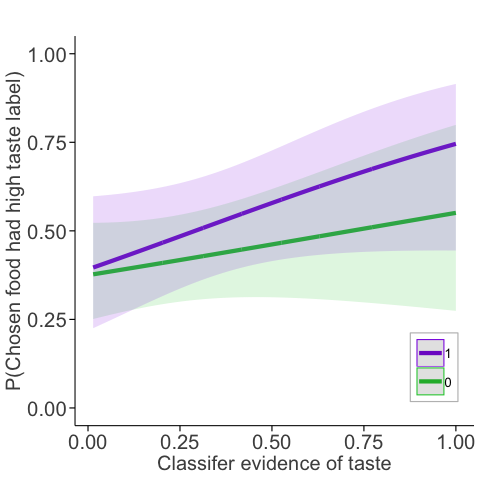

In [111]:
%%R -i taste_data_mod

taste_mod=glmer(chosen_food_high_rating ~ classifier_evidence * groupN + (classifier_evidence|subjid), family='binomial', data=taste_data_mod)
print(summary(taste_mod))
taste_plot <- plot_model(taste_mod,type='eff',show.ci=F, show.values=T,p.kr=FALSE,terms=c('classifier_evidence [all]','groupN'),axis.lim=c(0,1),color=cbPalette,line.size=2,legend.title='') +
    labs(title="",y="P(Chosen food had high taste label)", x="Classifer evidence of taste") + 
    scale_color_manual(values=cbPalette,guide = guide_legend(reverse = TRUE)) + 
    scale_fill_manual(values=cbPalette) + 
    theme(legend.key = element_rect(fill = 'white'), axis.title=element_text(size=20,), title=element_text(size=20,hjust = 0.5), 
          legend.title=element_text(size=0,), legend.background = element_rect(colour = "grey"), 
          legend.key.size = unit(1, "cm"), legend.position = c(0.9, 0.15))
    
taste_plot

In [112]:
%%R
print(coef(summary(taste_mod)))

                              Estimate Std. Error    z value   Pr(>|z|)
(Intercept)                -0.51120207  0.3068540 -1.6659454 0.09572428
classifier_evidence         0.71511101  0.7004843  1.0208809 0.30731088
groupN                      0.06979728  0.5233171  0.1333747 0.89389703
classifier_evidence:groupN  0.80179388  1.1300918  0.7094945 0.47801769


In [113]:
%%R
print(exp(coef(summary(taste_mod))))

                            Estimate Std. Error   z value Pr(>|z|)
(Intercept)                0.5997742   1.359143 0.1890119 1.100456
classifier_evidence        2.0444136   2.014728 2.7756387 1.359764
groupN                     1.0722908   1.687616 1.1426781 2.444638
classifier_evidence:groupN 2.2295369   3.095941 2.0329633 1.612874


In [114]:
%%R
mod <- coef(summary(taste_mod))
lower95 <- exp(mod[,'Estimate'] - (1.96*mod[,'Std. Error']))
upper95 <- exp(mod[,'Estimate'] + (1.96*mod[,'Std. Error']))
ci = data.frame(lower95,upper95)
print(ci)

                             lower95   upper95
(Intercept)                0.3286914  1.094428
classifier_evidence        0.5179699  8.069247
groupN                     0.3844643  2.990674
classifier_evidence:groupN 0.2433667 20.425289


In [115]:
%%R
save_plot('FINAL_FIGURES/taste_logistic.png', fig = taste_plot, width = 14, height = 14,
          dpi = 500, label.color = "black",
          label.size = 2, axis.textsize = 1.3, axis.titlesize = 1.3,
          legend.textsize = 1.2, legend.titlesize = 1.2,
          legend.itemsize = 0.4)

save_plot('FINAL_FIGURES/taste_logistic.svg', fig = taste_plot, width = 14, height = 14,
          dpi = 500, label.color = "black",
          label.size = 2, axis.textsize = 1.3, axis.titlesize = 1.3,
          legend.textsize = 1.2, legend.titlesize = 1.2,
          legend.itemsize = 0.4)

quartz_off_screen 
                2 


<a id='fig4b'></a>
## Figure 4b: use health evidence to predict choices

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
chosen_food_high_rating ~ classifier_evidence * groupN + (classifier_evidence |  
    subjid)
   Data: health_data_mod

     AIC      BIC   logLik deviance df.resid 
  2370.0   2411.4  -1178.0   2356.0     2696 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.3636 -0.6318  0.1394  0.4557  4.1452 

Random effects:
 Groups Name                Variance Std.Dev. Corr 
 subjid (Intercept)          3.681   1.919         
        classifier_evidence 11.478   3.388    -0.45
Number of obs: 2703, groups:  subjid, 41

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)  
(Intercept)                 -0.3725     0.6551  -0.569   0.5696  
classifier_evidence          1.3855     1.3083   1.059   0.2896  
groupN                      -0.6025     1.3732  -0.439   0.6608  
classifier_evidence:groupN   5.7012     2.7455   2.077   0.

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



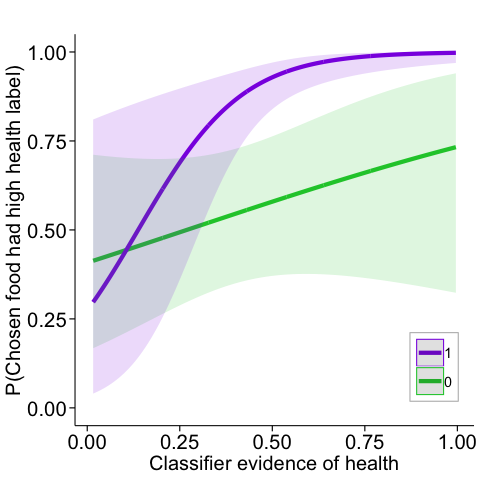

In [116]:
%%R -i health_data_mod
### Plot chose_health_item as function of health evidence
health_mod=glmer(chosen_food_high_rating ~ classifier_evidence * groupN + (classifier_evidence|subjid), family='binomial', data=health_data_mod)
print(summary(health_mod))
health_plot <- plot_model(health_mod,type='eff',show.ci=F, show.values=T,p.kr=FALSE,terms=c('classifier_evidence [all]','groupN'),axis.lim=c(0,1),color=cbPalette,line.size=2,legend.title='') + 
    labs(title="",y="P(Chosen food had high health label)", x="Classifier evidence of health") + 
    scale_color_manual(values=cbPalette,guide = guide_legend(reverse = TRUE)) + 
    scale_fill_manual(values=cbPalette) + 
    theme(legend.key = element_rect(fill = 'white'), axis.title=element_text(size=20,), title=element_text(size=20,hjust = 0.5), 
          legend.title=element_text(size=0,), legend.background = element_rect(colour = "grey"), 
          legend.key.size = unit(1, "cm"), legend.position = c(0.9, 0.15))

health_plot 

In [117]:
%%R
print(coef(summary(health_mod)))

                             Estimate Std. Error    z value  Pr(>|z|)
(Intercept)                -0.3725088  0.6550694 -0.5686554 0.5695900
classifier_evidence         1.3855451  1.3083147  1.0590305 0.2895859
groupN                     -0.6025480  1.3731657 -0.4388021 0.6608049
classifier_evidence:groupN  5.7011938  2.7455337  2.0765339 0.0378446


In [118]:
%%R
print(exp(coef(summary(health_mod))))

                              Estimate Std. Error   z value Pr(>|z|)
(Intercept)                  0.6890036   1.925276 0.5662863 1.767542
classifier_evidence          3.9970040   3.699933 2.8835739 1.335874
groupN                       0.5474150   3.947828 0.6448083 1.936350
classifier_evidence:groupN 299.2244024  15.572923 7.9767727 1.038570


In [119]:
%%R
mod <- coef(summary(health_mod))
lower95 <- exp(mod[,'Estimate'] - (1.96*mod[,'Std. Error']))
upper95 <- exp(mod[,'Estimate'] + (1.96*mod[,'Std. Error']))
ci = data.frame(lower95,upper95)
print(ci)

                              lower95      upper95
(Intercept)                0.19081617     2.487871
classifier_evidence        0.30766257    51.927151
groupN                     0.03710689     8.075677
classifier_evidence:groupN 1.37705585 65019.325828


In [120]:
%%R
save_plot('FINAL_FIGURES/health_logistic.png', fig = health_plot, width = 14, height = 14,
          dpi = 500, label.color = "black",
          label.size = 2, axis.textsize = 1.3, axis.titlesize = 1.3,
          legend.textsize = 1.2, legend.titlesize = 1.2,
          legend.itemsize = 0.4)

save_plot('FINAL_FIGURES/health_logistic.svg', fig = health_plot, width = 14, height = 14,
          dpi = 500, label.color = "black",
          label.size = 2, axis.textsize = 1.3, axis.titlesize = 1.3,
          legend.textsize = 1.2, legend.titlesize = 1.2,
          legend.itemsize = 0.4)

quartz_off_screen 
                2 


<a id='fig4cd'></a>
## Figure 4c and 4d: Cross-task classification (validation)

##### Note: choice classification analyses were conducted on entire OFC (lOFC + mOFC) because within-task classification performance didn't differ between lOFC and mOFC

HC, taste
Ttest_1sampResult(statistic=5.265645736516241, pvalue=1.8717449305598546e-05) 21
AN, taste
Ttest_1sampResult(statistic=0.5262964506577242, pvalue=0.3023860817234779) 20
Ttest_indResult(statistic=0.9755326858859072, pvalue=0.3353085599450967)
HC, health
Ttest_1sampResult(statistic=2.5616561186119435, pvalue=0.009302138980186992) 21
AN, health
Ttest_1sampResult(statistic=2.4413345929043304, pvalue=0.012295382645028516) 20
Ttest_indResult(statistic=-0.9258988393307784, pvalue=0.36019289623130524)


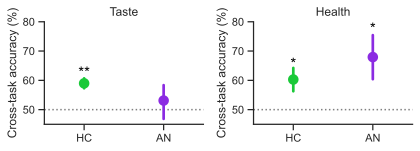

In [121]:
sns.set(style="ticks", palette="bright", color_codes=True, font_scale=1)
taste_data_m = taste_data_mod.groupby(['subjid','group','label'],as_index=False).mean()
health_data_m = health_data_mod.groupby(['subjid','group','label'],as_index=False).mean()
taste_data_m['cross_task_accuracy'] = taste_data_m['cross_task_accuracy']*100 # rescale to 0-100
health_data_m['cross_task_accuracy'] = health_data_m['cross_task_accuracy']*100 # rescale to 0-100
tmp1 = taste_data_m.loc[(taste_data_m['label']=='taste')&(taste_data_m['group']=='HC'),'cross_task_accuracy']
tmp2 = taste_data_m.loc[(taste_data_m['label']=='taste')&(taste_data_m['group']=='AN'),'cross_task_accuracy']
print('HC, taste')
ttest = stats.ttest_1samp(tmp1,50,alternative='greater')
print(ttest, len(tmp1))
print('AN, taste')
ttest = stats.ttest_1samp(tmp2,50,alternative='greater')
print(ttest, len(tmp2))
print(stats.ttest_ind(tmp1,tmp2))

tmp1 = health_data_m.loc[(health_data_m['label']=='health')&(health_data_m['group']=='HC'),'cross_task_accuracy']
tmp2 = health_data_m.loc[(health_data_m['label']=='health')&(health_data_m['group']=='AN'),'cross_task_accuracy']
print('HC, health')
ttest = stats.ttest_1samp(tmp1,50,alternative='greater')
print(ttest, len(tmp1))
print('AN, health')
ttest = stats.ttest_1samp(tmp2,50,alternative='greater')
print(ttest, len(tmp2))
print(stats.ttest_ind(tmp1,tmp2))

fig, axes = plt.subplots(1,2,sharex=True,figsize=(6,2.5),dpi=300)
sns.pointplot(x='group',y='cross_task_accuracy',palette=["g", "m"],order=['HC','AN'],join=False,ci=68,dodge=.2,scale=1.2,data=taste_data_m,ax=axes[0])
sns.pointplot(x='group',y='cross_task_accuracy',palette=["g", "m"],order=['HC','AN'],join=False,ci=68,dodge=.2,scale=1.2,data=health_data_m,ax=axes[1])

axes[0].text(0,61,'**',fontsize=15,color='black',ha='center')
axes[1].text(0,64,'*',fontsize=15,color='black',ha='center')
axes[1].text(1,76,'*',fontsize=15,color='black',ha='center')

axes[0].set_ylabel('Cross-task accuracy (%)')
axes[1].set_ylabel('Cross-task accuracy (%)')
axes[0].set_title('Taste')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[1].set_title('Health')
axes[0].axhline(50,linestyle=':',zorder=0,color='gray')
axes[1].axhline(50,linestyle=':',zorder=0,color='gray')
plt.tight_layout()
#plt.suptitle('Cross-task classification of attributes of the chosen food',fontsize=12)
plt.subplots_adjust(top=0.75)
axes[0].set_ylim([45,80])
plt.ylim(45,80)
sns.despine()
plt.savefig('FINAL_FIGURES/choice_cross_validation.png', bbox_inches = "tight", dpi=500)
plt.savefig('FINAL_FIGURES/choice_cross_validation.svg', bbox_inches = "tight", dpi=500)
plt.show()

### compare cross-task decoding using taste/health of choice item vs. alternative item

In [122]:
taste_data_m = taste_data_mod.groupby(['subjid','group','label'],as_index=False).mean()
health_data_m = health_data_mod.groupby(['subjid','group','label'],as_index=False).mean()
taste_data_m['cross_task_accuracy'] = taste_data_m['cross_task_accuracy']*100 # rescale to 0-100
health_data_m['cross_task_accuracy'] = health_data_m['cross_task_accuracy']*100 # rescale to 0-100
taste_data_m['cross_task_accuracy_alt'] = taste_data_m['cross_task_accuracy_alt']*100 # rescale to 0-100
health_data_m['cross_task_accuracy_alt'] = health_data_m['cross_task_accuracy_alt']*100 # rescale to 0-100

tmp1 = taste_data_m[['subjid','cross_task_accuracy_alt','group','label']].copy()
tmp2 = taste_data_m[['subjid','cross_task_accuracy','group','label']].copy()
tmp1['Accuracy'] = tmp1['cross_task_accuracy_alt']
tmp2['Accuracy'] = tmp2['cross_task_accuracy']
tmp1['choice_comparison'] = 'Alternative food'
tmp2['choice_comparison'] = 'Chosen food'
data = pd.concat([tmp1,tmp2])
choice_decode_df = data

tmp1 = health_data_m[['subjid','cross_task_accuracy_alt','group','label']].copy()
tmp2 = health_data_m[['subjid','cross_task_accuracy','group','label']].copy()
tmp1['Accuracy'] = tmp1['cross_task_accuracy_alt']
tmp2['Accuracy'] = tmp2['cross_task_accuracy']
tmp1['choice_comparison'] = 'Alternative food'
tmp2['choice_comparison'] = 'Chosen food'
data = pd.concat([tmp1,tmp2])

choice_decode_df = pd.concat([choice_decode_df,data])
# deviation coding
choice_decode_df.replace({'taste':-1,'health':1},inplace=True)
choice_decode_df.replace({'HC':-1,'AN':1},inplace=True)

In [123]:
%%R -i choice_decode_df
cmod = lmer(Accuracy ~ choice_comparison * label * group + (1|subjid), data = choice_decode_df)
print(summary(cmod))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Accuracy ~ choice_comparison * label * group + (1 | subjid)
   Data: choice_decode_df

REML criterion at convergence: 1356.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4375 -0.2737  0.0658  0.3988  2.4387 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjid   (Intercept)  43.7     6.611  
 Residual             244.4    15.632  
Number of obs: 164, groups:  subjid, 41

Fixed effects:
                                         Estimate Std. Error      df t value
(Intercept)                                54.070      2.012  87.781  26.874
choice_comparisonChosen food                6.006      2.442 117.000   2.459
label                                      -0.204      1.727 117.000  -0.118
group                                      -2.157      2.012  87.781  -1.072
choice_comparisonChosen food:label          4.238      2.442 117.000   1.736
choice_comparisonChosen

In [124]:
%%R
print('choice_comparison')
est <- coef(summary(cmod))['choice_comparisonChosen food','Estimate']
se <- coef(summary(cmod))['choice_comparisonChosen food','Std. Error']
print(c('beta:',format(c(est),digits=2,nsmall=2)))
print(c('95% CI:',format(c(est-(1.96*se),est+(1.96*se)),digits=2,nsmall=2)))

[1] "choice_comparison"
[1] "beta:" "6.01" 
[1] "95% CI:" " 1.22"   "10.79"  


<a id='fig4e'></a>
## Figure 4e: Taste classifier evidence and choice rating

In [125]:
%%R -i taste_data_mod
taste_mod=lmer(choice_rating ~ classifier_evidence * groupN * alternative + (classifier_evidence|subjid), data=taste_data_mod)
print(summary(taste_mod))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: choice_rating ~ classifier_evidence * groupN * alternative +  
    (classifier_evidence | subjid)
   Data: taste_data_mod

REML criterion at convergence: 9025.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9642 -0.6373 -0.0041  0.7195  3.3232 

Random effects:
 Groups   Name                Variance Std.Dev. Corr 
 subjid   (Intercept)         0.46634  0.6829        
          classifier_evidence 0.01002  0.1001   -1.00
 Residual                     1.62084  1.2731        
Number of obs: 2682, groups:  subjid, 41

Fixed effects:
                                                    Estimate Std. Error
(Intercept)                                          3.14834    0.24221
classifier_evidence                                  1.07570    0.42288
groupN                                               0.02479    0.38316
alternative1_Not_Tasty                               0.32417    

In [126]:
%%R
mod <- coef(summary(taste_mod))
lower95 <- mod[,'Estimate'] - (1.96*mod[,'Std. Error'])
upper95 <- mod[,'Estimate'] + (1.96*mod[,'Std. Error'])
ci = data.frame(lower95,upper95)
print(ci)

                                                      lower95    upper95
(Intercept)                                        2.67360520  3.6230813
classifier_evidence                                0.24685548  1.9045541
groupN                                            -0.72621103  0.7757892
alternative1_Not_Tasty                            -0.05444612  0.7027876
classifier_evidence:groupN                        -1.03854510  1.5217481
classifier_evidence:alternative1_Not_Tasty        -1.99636979 -0.3663468
groupN:alternative1_Not_Tasty                     -1.46702859 -0.2614215
classifier_evidence:groupN:alternative1_Not_Tasty -2.69584976 -0.2749478


<a id='fig4f'></a>
## Figure 4f: Health classifier evidence and choice rating 

In [127]:
%%R -i health_data_mod
health_mod=lmer(choice_rating ~ classifier_evidence * groupN * alternative + (classifier_evidence|subjid), data=health_data_mod)
print(summary(health_mod))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: choice_rating ~ classifier_evidence * groupN * alternative +  
    (classifier_evidence | subjid)
   Data: health_data_mod

REML criterion at convergence: 9119.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7864 -0.6107  0.0024  0.7121  3.0788 

Random effects:
 Groups   Name                Variance Std.Dev. Corr 
 subjid   (Intercept)         1.051    1.025         
          classifier_evidence 2.973    1.724    -0.80
 Residual                     1.629    1.276         
Number of obs: 2703, groups:  subjid, 41

Fixed effects:
                                                      Estimate Std. Error
(Intercept)                                            3.77990    0.35908
classifier_evidence                                   -0.41181    0.69588
groupN                                                -1.02490    0.59631
alternative1_Not_Healthy                              -

In [128]:
%%R
mod <- coef(summary(health_mod))
lower95 <- mod[,'Estimate'] - (1.96*mod[,'Std. Error'])
upper95 <- mod[,'Estimate'] + (1.96*mod[,'Std. Error'])
ci = data.frame(lower95,upper95)
print(ci)

                                                       lower95    upper95
(Intercept)                                          3.0760937  4.4837019
classifier_evidence                                 -1.7757292  0.9521011
groupN                                              -2.1936615  0.1438544
alternative1_Not_Healthy                            -0.6212873  0.1964148
classifier_evidence:groupN                           0.2873696  4.7242016
classifier_evidence:alternative1_Not_Healthy        -0.8017252  0.9338287
groupN:alternative1_Not_Healthy                     -0.7719994  0.7927633
classifier_evidence:groupN:alternative1_Not_Healthy -4.8601406 -1.8096282


In [129]:
# just plot binned data for alternative==tasty or alternative==healthy
tasty_data = taste_data_mod.loc[taste_data_mod['alternative']=='0_Tasty'].copy()
healthy_data = health_data_mod.loc[health_data_mod['alternative']=='0_Healthy'].copy()

# create 4 bins: (-0.001, 0.25], (0.25, 0.5], (0.5, 0.75], (0.75, 1.0]
nbins = 4

# sort each data point into each bin
for sub in tasty_data.subjid.unique():
    ev_values = tasty_data.loc[tasty_data['subjid']==sub,'classifier_evidence']
    bins = pd.qcut(np.linspace(0, 1, nbins), nbins)
    uniq_bins = bins.unique()
    uniq_bins = np.sort(uniq_bins)
    for i in range(len(uniq_bins)):
        b = uniq_bins[i]
        # add bin interval as column
        tasty_data.loc[(tasty_data['subjid']==sub) & (tasty_data['classifier_evidence']>b.left) & (tasty_data['classifier_evidence']<=b.right),'ev_bin'] = b
        # get classifier evidence for each bin
        bin_data = tasty_data.loc[(taste_data_mod['subjid']==sub) & (tasty_data['ev_bin']==b),'classifier_evidence']
        # set mean classifier evidence in each bin
        tasty_data.loc[(tasty_data['subjid']==sub) & (tasty_data['ev_bin']==b),'bin_mean'] = bin_data.mean()
        # number each bin
        tasty_data.loc[(tasty_data['subjid']==sub) & (tasty_data['ev_bin']==b),'binN'] = i

for sub in healthy_data.subjid.unique():
    ev_values = healthy_data.loc[healthy_data['subjid']==sub,'classifier_evidence']
    bins = pd.qcut(np.linspace(0, 1, nbins), nbins)
    uniq_bins = bins.unique()
    uniq_bins = np.sort(uniq_bins)
    for i in range(len(uniq_bins)):
        b = uniq_bins[i]
        # add bin interval as column
        healthy_data.loc[(healthy_data['subjid']==sub) & (healthy_data['classifier_evidence']>b.left) & (healthy_data['classifier_evidence']<=b.right),'ev_bin'] = b
        # get classifier evidence for each bin
        bin_data = healthy_data.loc[(healthy_data['subjid']==sub) & (healthy_data['ev_bin']==b),'classifier_evidence']
        # set mean classifier evidence in each bin
        healthy_data.loc[(healthy_data['subjid']==sub) & (healthy_data['ev_bin']==b),'bin_mean'] = bin_data.mean()
        # number each bin
        healthy_data.loc[(healthy_data['subjid']==sub) & (healthy_data['ev_bin']==b),'binN'] = i

In [130]:
# calculate means for each bins and calculate sem for each bin
dataT = tasty_data.groupby(['group','subjid','bin_mean','binN'],as_index=False).mean()
dataT_m = dataT.groupby(['group','binN'],as_index=False).mean()
dataT_count = dataT.groupby(['group','binN'],as_index=False).count() # get number of subjects in each bin
dataT_std = dataT.groupby(['group','binN'],as_index=False).std()
dataT_std['choice_rating'] = dataT_std['choice_rating']/np.sqrt(dataT_count['choice_rating'])
assert np.array_equal(dataT_m['group'],dataT_std['group'])
assert np.array_equal(dataT_m['binN'],dataT_std['binN'])
dataT_m['choice_rating_sem'] = dataT_std['choice_rating']

# average data across bins and calculate sem for each bin
dataH = healthy_data.groupby(['group','subjid','bin_mean','binN'],as_index=False).mean()
dataH_m = dataH.groupby(['group','binN'],as_index=False).mean()
dataH_count = dataH.groupby(['group','binN'],as_index=False).count() # get number of subjects in each bin
dataH_std = dataH.groupby(['group','binN'],as_index=False).std()
dataH_std['choice_rating'] = dataH_std['choice_rating']/np.sqrt(dataH_count['choice_rating'])
assert np.array_equal(dataH_m['group'],dataH_std['group'])
assert np.array_equal(dataH_m['binN'],dataH_std['binN'])
dataH_m['choice_rating_sem'] = dataH_std['choice_rating']

<a id='fig4ef'></a>
## Figure 4e-4f: Predict magnitude of choice preferences from classifier evidence

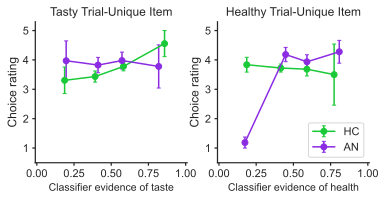

In [131]:
fig = plt.figure(dpi=300,figsize=(6,2.6))
    
ax_taste = fig.add_subplot(1, 2, 1)
plt.title('Tasty Trial-Unique Item')

HC_dataT = dataT_m.loc[dataT_m['group']=='HC']
AN_dataT = dataT_m.loc[dataT_m['group']=='AN']

HC_dataH = dataH_m.loc[dataH_m['group']=='HC']
AN_dataH = dataH_m.loc[dataH_m['group']=='AN']

ax_taste.set_xlim((-0.01, 1.01))
ax_taste.set_ylim((0.5, 5.3))

ax_health = fig.add_subplot(1, 2, 2)
plt.title('Healthy Trial-Unique Item')

ax_health.set_xlim((-0.01, 1.01))
ax_health.set_ylim((0.5, 5.3))

ax_taste.set_xlabel('Classifier evidence of taste',fontsize=10.5)
ax_taste.set_ylabel('Choice rating')

ax_health.set_xlabel('Classifier evidence of health',fontsize=10.5)
ax_health.set_ylabel('Choice rating')

ms = 6 # marker size
cs = 2 # cap size
ew = 1.5 # error bar width

green = "#1ac938"
purple = "#8b2be2"

ax_taste.errorbar(HC_dataT['bin_mean'], HC_dataT['choice_rating'], yerr=HC_dataT['choice_rating_sem'], color=green, markerfacecolor=green,
                   capsize=cs, marker='o',label="HC", markersize=ms, elinewidth=ew)

ax_taste.errorbar(AN_dataT['bin_mean'], AN_dataT['choice_rating'], yerr=AN_dataT['choice_rating_sem'], color=purple, markerfacecolor=purple,
                   capsize=cs, marker='o',label="AN", markersize=ms, elinewidth=ew)

ax_health.errorbar(HC_dataH['bin_mean'], HC_dataH['choice_rating'], yerr=HC_dataH['choice_rating_sem'], color=green, markerfacecolor=green,
                   capsize=cs, marker='o',label="HC", markersize=ms, elinewidth=ew)

ax_health.errorbar(AN_dataH['bin_mean'], AN_dataH['choice_rating'], yerr=AN_dataH['choice_rating_sem'], color=purple, markerfacecolor=purple,
                   capsize=cs, marker='o',label="AN", markersize=ms, elinewidth=ew)

ax_taste.set_xticks(np.linspace(0, 1, 5))
ax_health.set_xticks(np.linspace(0, 1, 5))

ax_taste.tick_params('both', length=3, which='major')
ax_health.tick_params('both', length=3, which='major')

ax_taste.spines['right'].set_visible(False)
ax_taste.spines['top'].set_visible(False)
ax_health.spines['right'].set_visible(False)
ax_health.spines['top'].set_visible(False)

plt.legend(loc='lower right')
plt.savefig('FINAL_FIGURES/choice_rating_evidence_binned.png', bbox_inches = "tight", dpi=500)
plt.savefig('FINAL_FIGURES/choice_rating_evidence_binned.svg', bbox_inches = "tight", dpi=500)
plt.show()

### Compare within-task decoding accuracies for HC subjects with median = 5 and median < 5

In [132]:
median_data = median_df.loc[median_df['label']=='taste'].groupby(['subjid'],as_index=False).mean()[['subjid','median']]

In [133]:
data = class_results.loc[(class_results['label']=='taste') & (class_results['rating_block_fmri_activity']=='taste')]
perm_data = perm_results.loc[(perm_results['label']=='taste') & (perm_results['rating_block_fmri_activity']=='taste')]

In [134]:
data = data.merge(median_data)

In [135]:
data['median5'] = data['median'] == 5

In [136]:
data.groupby(['group','median5','region']).count()

within_task_decoding_accuracy  \
group median5 region                                  
AN    False   lOFC                               19   
              mOFC                               19   
      True    lOFC                                1   
              mOFC                                1   
HC    False   lOFC                               11   
              mOFC                               11   
      True    lOFC                               10   
              mOFC                               10   

                      rating_block_fmri_activity  label  subjid  median  
group median5 region                                                     
AN    False   lOFC                            19     19      19      19  
              mOFC                            19     19      19      19  
      True    lOFC                             1      1       1       1  
              mOFC                             1      1       1       1  
HC    False   lOFC                            11     11      11      11  
              mOFC                            11     11      11      11  
      True    lOFC                            10     10      10      10  
              mOFC                            10     10      10      10

In [137]:
data.groupby(['group','median5','region']).mean()

within_task_decoding_accuracy    median
group median5 region                                         
AN    False   lOFC                        54.797371  3.473684
              mOFC                        57.014822  3.473684
      True    lOFC                        63.643791  5.000000
              mOFC                        66.176471  5.000000
HC    False   lOFC                        53.728070  4.000000
              mOFC                        55.077087  4.000000
      True    lOFC                        62.046784  5.000000
              mOFC                        61.498538  5.000000

In [138]:
tmp1 = data.loc[(data['label']=='taste') & (data['median5'] == True) & (data['group']=='HC'),'within_task_decoding_accuracy']
tmp2 = data.loc[(data['label']=='taste') & (data['median5'] == False) & (data['group']=='HC'),'within_task_decoding_accuracy']
stats.ttest_ind(tmp1,tmp2)

Ttest_indResult(statistic=3.134000177825199, pvalue=0.0032243374425871885)

In [139]:
# perform a permutation
diff = tmp1.mean() - tmp2.mean() # sample difference between means for HC participants with median == 5 and median < 5 (across both ROIs)
n_data_in_group_1 = 20
acc = data.loc[(data['label']=='taste') & (data['group']=='HC'),'within_task_decoding_accuracy'].values
perm_diff = np.zeros(1000)
for i in range(0,1000): # 1000 shuffles
    random.shuffle(acc)
    fake_group1 = acc[0:n_data_in_group_1] # median5
    fake_group2 = acc[n_data_in_group_1:] # median5
    perm_diff[i] = fake_group1.mean() - fake_group2.mean()
print('95th percentile:', np.quantile(perm_diff,0.95))
print('p='+str(np.mean(perm_diff > diff)))

95th percentile: 4.405269803296122
p=0.004


<a id='indiv_dist'></a>
## Supplemental plots of individual rating distributions

In [140]:
data = rating_data

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


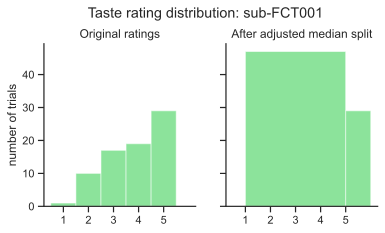

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


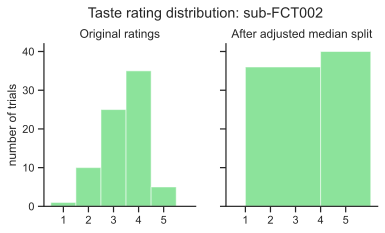

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


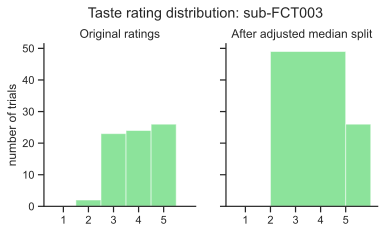

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


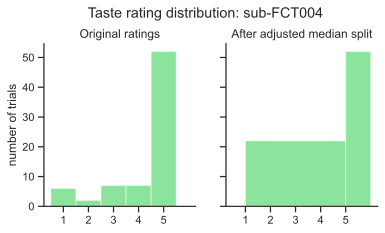

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


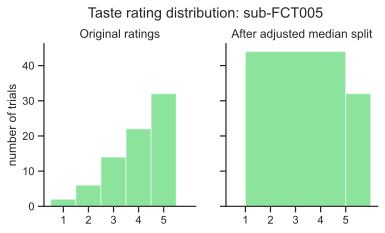

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


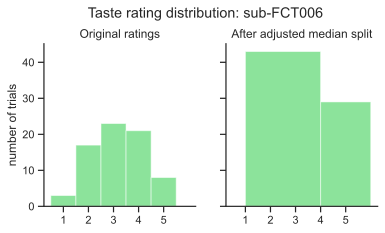

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


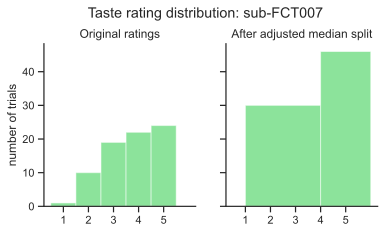

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


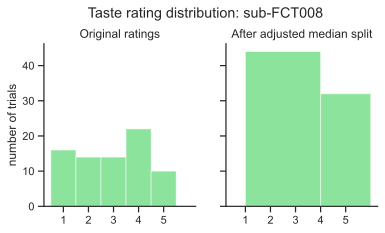

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


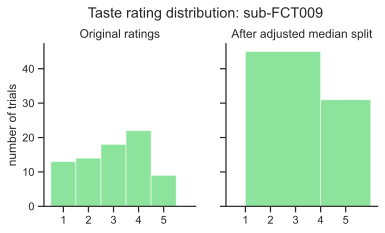

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


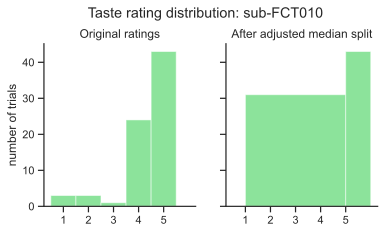

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


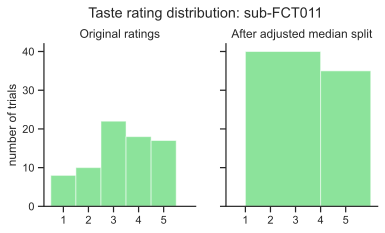

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


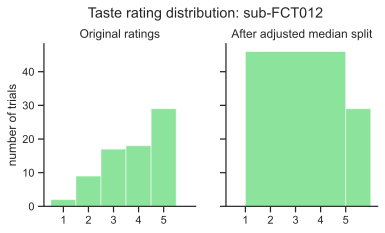

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


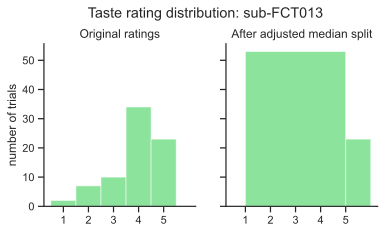

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


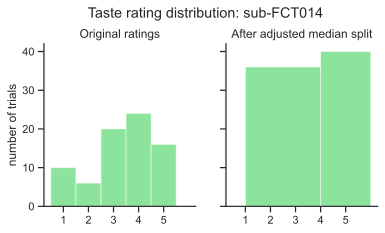

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


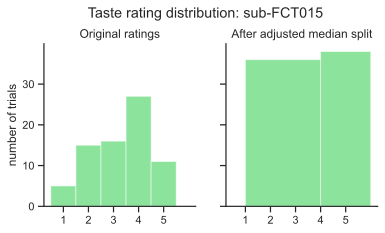

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


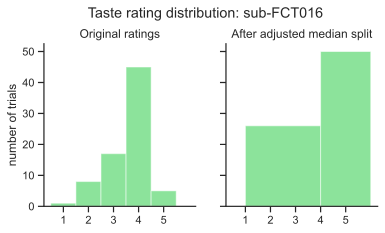

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


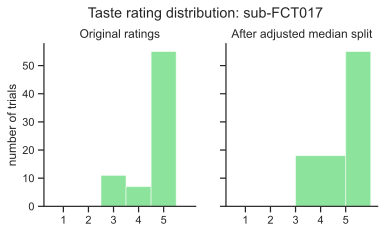

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


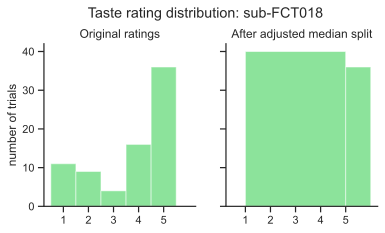

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


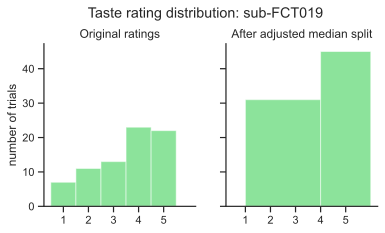

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


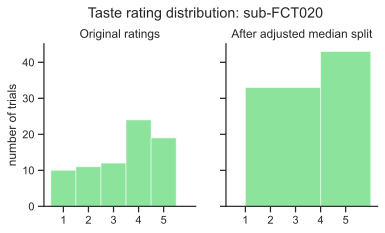

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


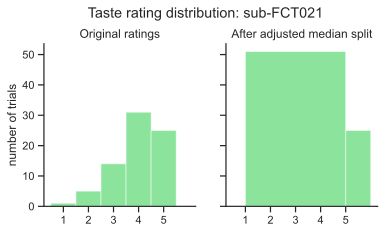

low taste class ratings: [1, 2, 3, 4]
high taste class ratings: [5]


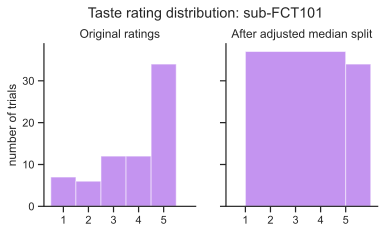

low taste class ratings: [1, 2]
high taste class ratings: [3, 4, 5]


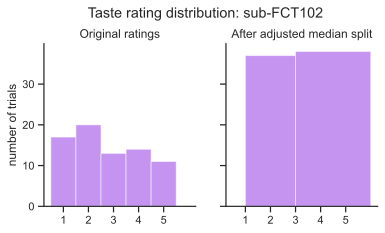

low taste class ratings: [1]
high taste class ratings: [2, 3, 4, 5]


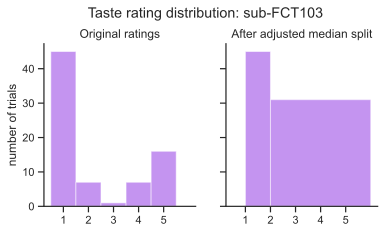

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


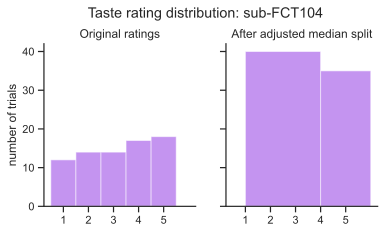

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


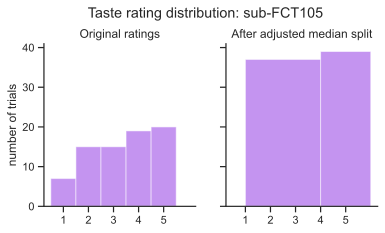

low taste class ratings: [1, 2]
high taste class ratings: [3, 4, 5]


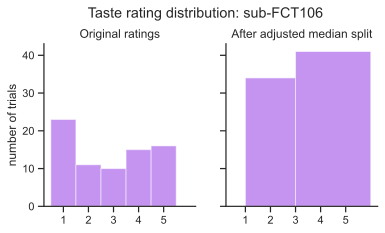

low taste class ratings: [1, 2]
high taste class ratings: [3, 4, 5]


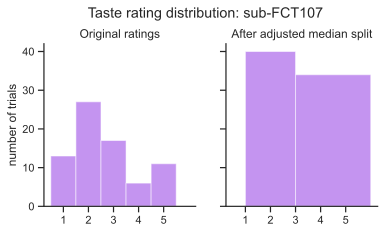

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


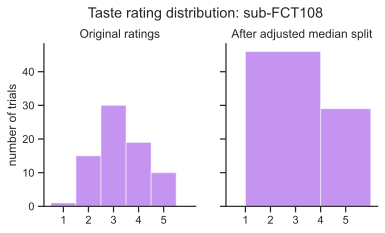

low taste class ratings: [1, 2]
high taste class ratings: [3, 4, 5]


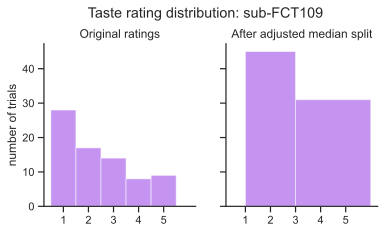

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


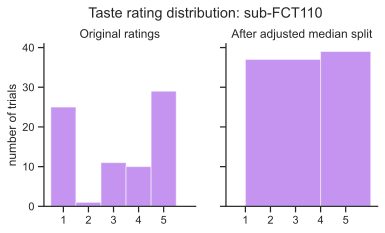

low taste class ratings: [1, 2]
high taste class ratings: [3, 4, 5]


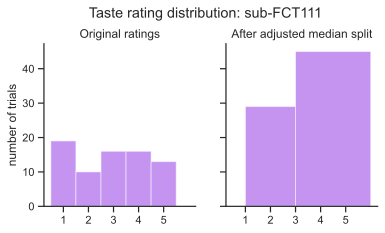

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


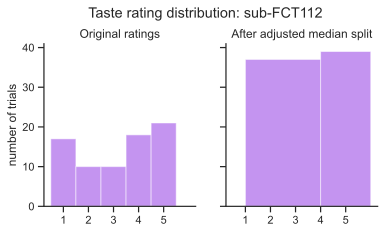

low taste class ratings: [1, 2]
high taste class ratings: [3, 4, 5]


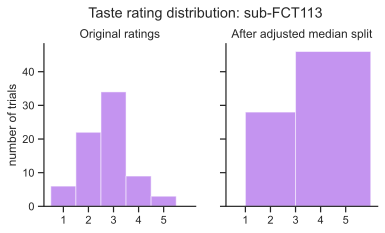

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


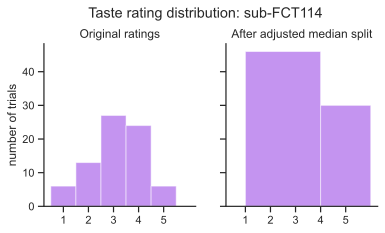

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


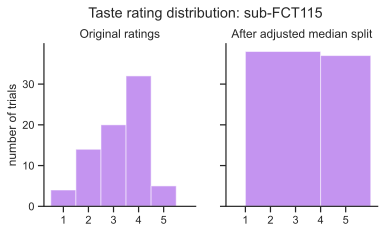

low taste class ratings: [1, 2]
high taste class ratings: [3, 4, 5]


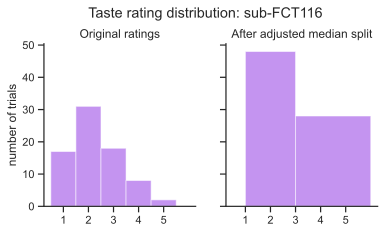

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


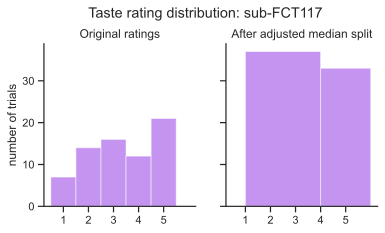

low taste class ratings: [1, 2]
high taste class ratings: [3, 4, 5]


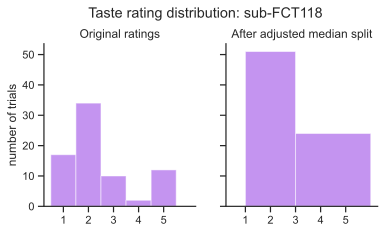

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


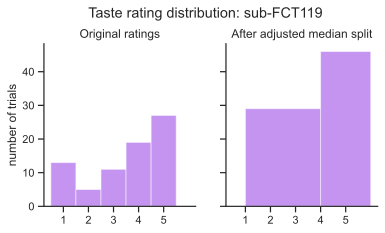

low taste class ratings: [1, 2]
high taste class ratings: [3, 4, 5]


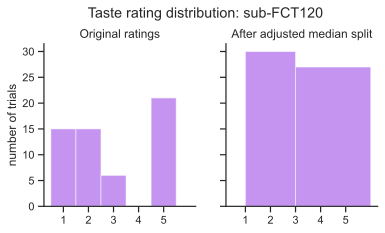

low taste class ratings: [1, 2, 3]
high taste class ratings: [4, 5]


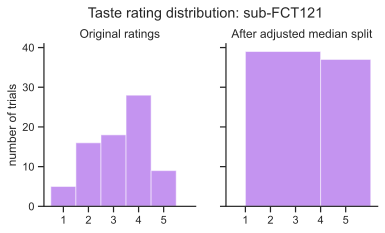

In [141]:
# plot individual subject rating distributions
subjids = data.subjid.unique()
ratingType = 'taste_rating'
for sub in data['subjid'].unique():
    ratings = data.loc[data['subjid']==sub]
    ratings = ratings.loc[~np.isnan(ratings[ratingType])][ratingType].values
    start_of_second_bin = trial_class_median_split_py3.get_second_bin_starting_rating(sub,ratingType,'../behav')
    print("low taste class ratings:", list(range(1,start_of_second_bin)))
    print("high taste class ratings:", list(range(start_of_second_bin,6)))
    color = 'g' if sub.startswith('sub-FCT0') else 'm'
    
    f, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=True, dpi=100)
    axes[0].hist(ratings,bins=[1,2,3,4,5,6],color=color,align="left",alpha=0.5)
    #sns.distplot(ratings,kde=False,label=sub,bins=[1,2,3,4,5,6],ax=axes[0],color=color)
    axes[1].hist(ratings,bins=[np.min(ratings),start_of_second_bin,np.max(ratings)+1],color=color,alpha=0.5)
    #sns.distplot(ratings, kde=False, label=sub, bins=[np.min(ratings),start_of_second_bin,np.max(ratings)+1],ax=axes[1],color=color)
    
    axes[0].set_xticks(ticks=[1,2,3,4,5])
    axes[0].set_ylabel('number of trials')
    axes[0].set_title('Original ratings')
    axes[1].set_title('After adjusted median split')
    f.suptitle('Taste rating distribution: ' + sub, y=1.05)
    sns.despine()
    plt.show()

low health class ratings: [1, 2, 3, 4]
high health class ratings: [5]


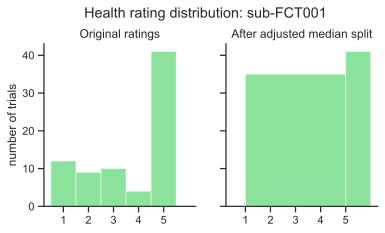

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


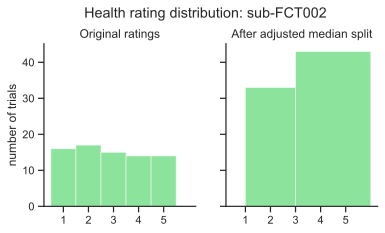

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


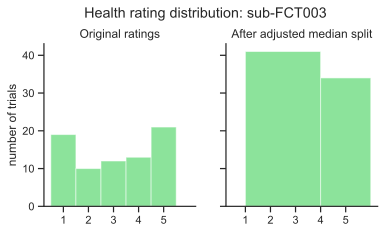

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


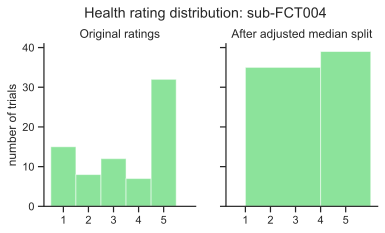

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


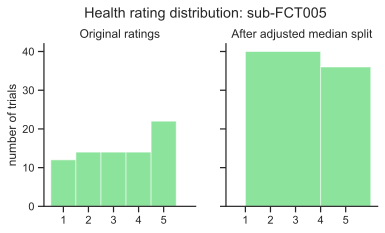

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


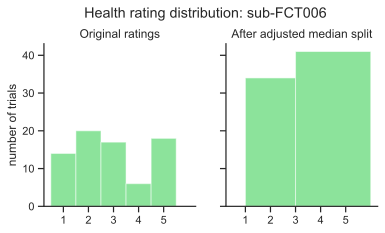

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


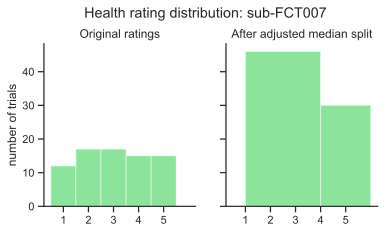

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


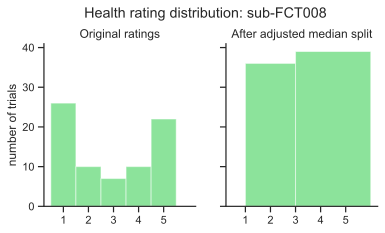

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


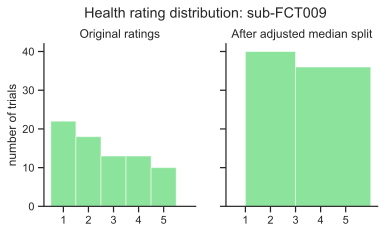

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


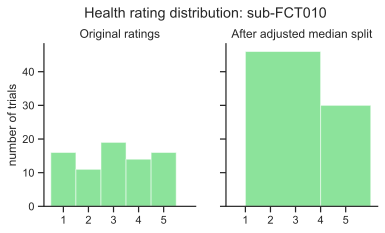

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


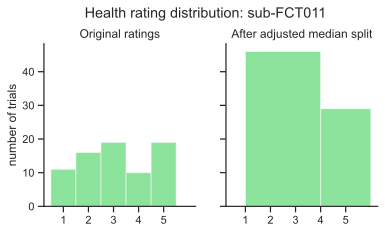

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


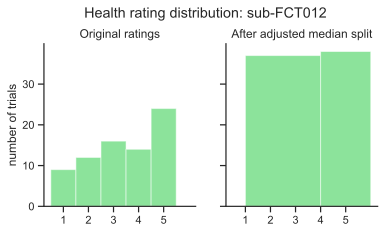

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


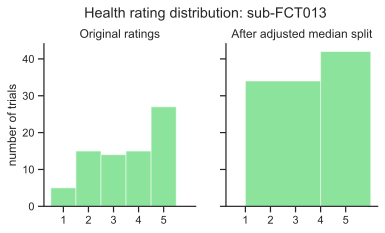

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


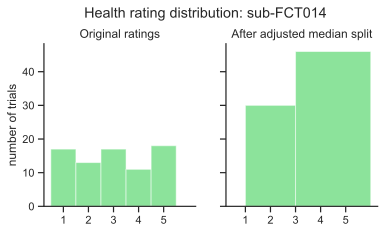

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


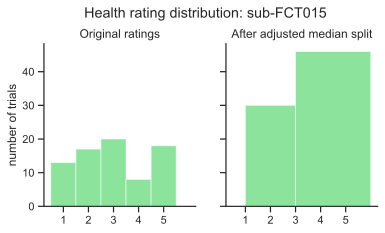

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


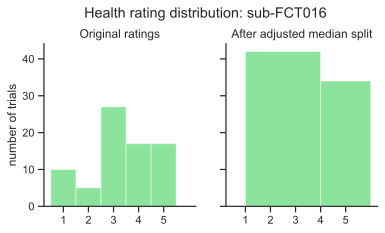

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


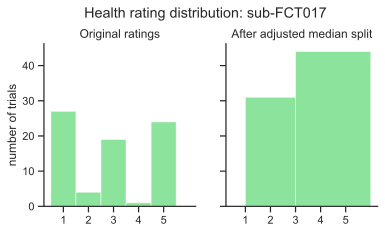

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


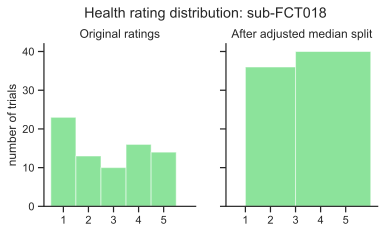

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


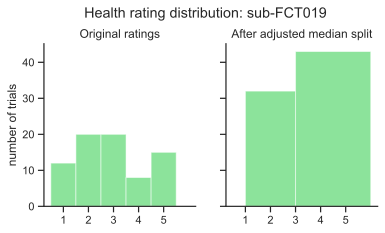

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


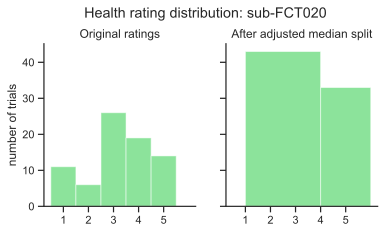

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


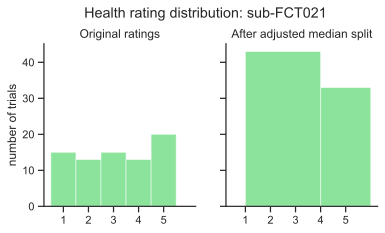

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


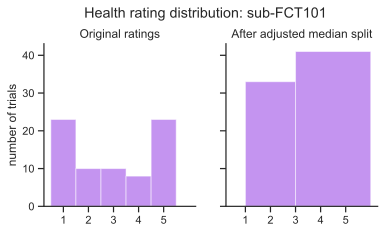

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


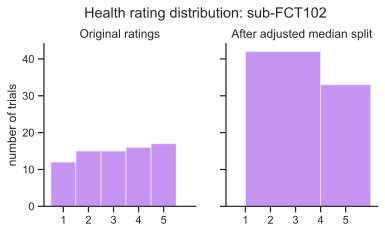

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


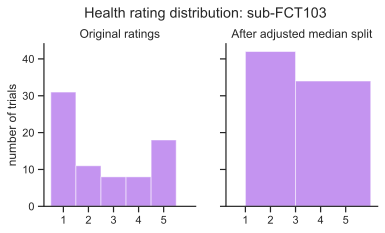

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


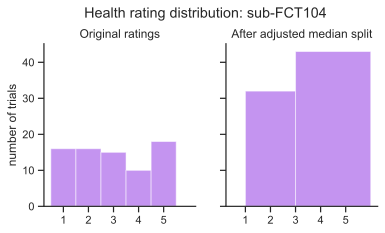

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


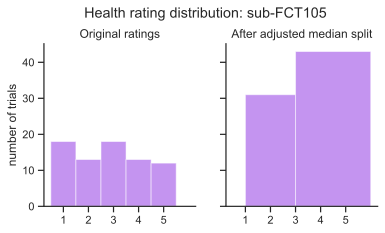

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


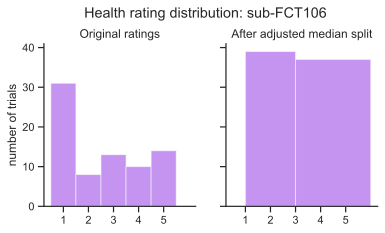

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


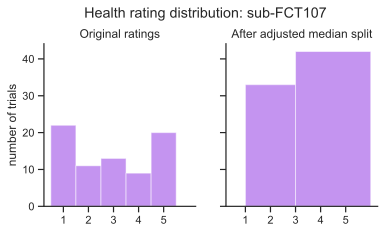

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


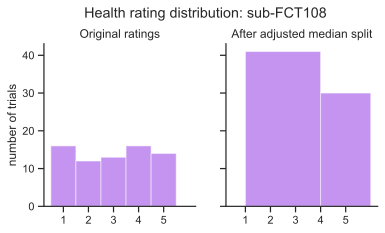

low health class ratings: [1]
high health class ratings: [2, 3, 4, 5]


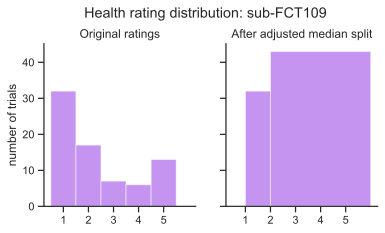

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


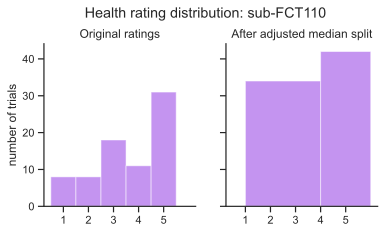

low health class ratings: [1]
high health class ratings: [2, 3, 4, 5]


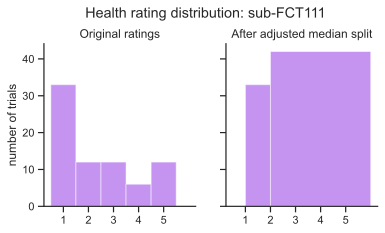

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


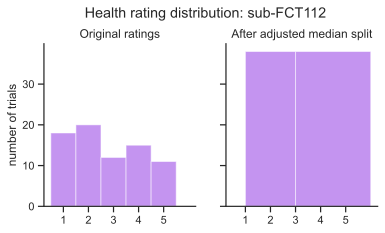

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


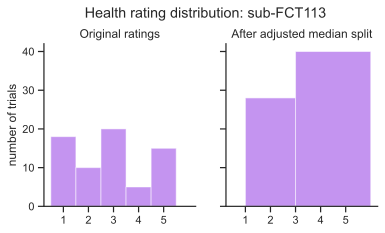

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


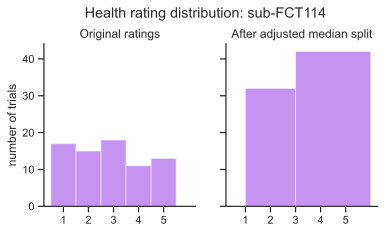

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


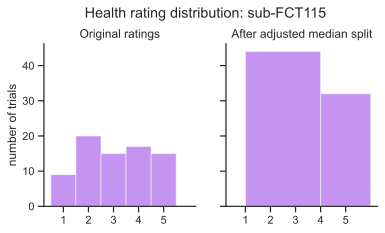

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


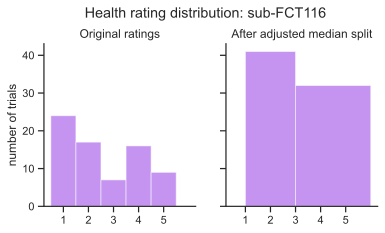

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


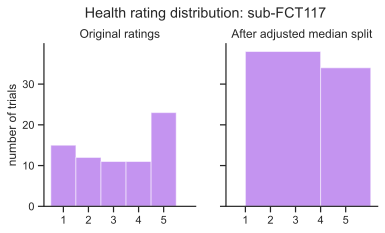

low health class ratings: [1]
high health class ratings: [2, 3, 4, 5]


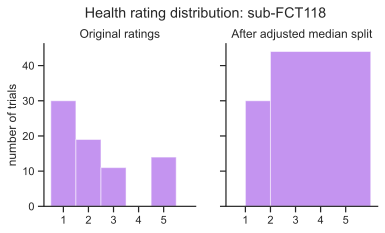

low health class ratings: [1]
high health class ratings: [2, 3, 4, 5]


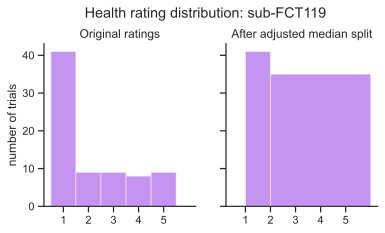

low health class ratings: [1, 2]
high health class ratings: [3, 4, 5]


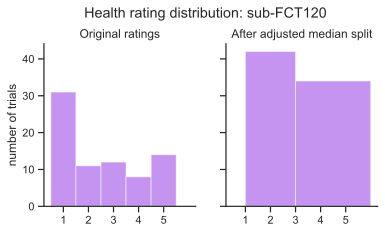

low health class ratings: [1, 2, 3]
high health class ratings: [4, 5]


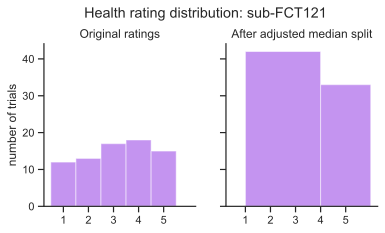

In [142]:
# plot individual subject rating distributions
subjids = data.subjid.unique()
ratingType = 'health_rating'
for sub in data['subjid'].unique():
    ratings = data.loc[data['subjid']==sub]
    ratings = ratings.loc[~np.isnan(ratings[ratingType])][ratingType].values
    start_of_second_bin = trial_class_median_split_py3.get_second_bin_starting_rating(sub,ratingType,'../behav')
    print("low health class ratings:", list(range(1,start_of_second_bin)))
    print("high health class ratings:", list(range(start_of_second_bin,6)))
    color = 'g' if sub.startswith('sub-FCT0') else 'm'
    
    f, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=True, dpi=100)
    axes[0].hist(ratings,bins=[1,2,3,4,5,6],color=color,align="left",alpha=0.5)
    #sns.distplot(ratings,kde=False,label=sub,bins=[1,2,3,4,5,6],ax=axes[0],color=color)
    axes[1].hist(ratings,bins=[np.min(ratings),start_of_second_bin,np.max(ratings)+1],color=color,alpha=0.5)
    #sns.distplot(ratings, kde=False, label=sub, bins=[np.min(ratings),start_of_second_bin,np.max(ratings)+1],ax=axes[1],color=color)
    
    axes[0].set_xticks(ticks=[1,2,3,4,5])
    axes[0].set_ylabel('number of trials')
    axes[0].set_title('Original ratings')
    axes[1].set_title('After adjusted median split')
    f.suptitle('Health rating distribution: ' + sub, y=1.05)
    sns.despine()
    plt.show()